# **Body Fat Prediction with Machine Learning**

## **Requirements**

In [110]:
import polars as pl
import pandas as pd
import numpy as np
import pickle
import sys
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
# Discretize
from sklearn.preprocessing import KBinsDiscretizer
# Imputers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Scalers
from sklearn.preprocessing import StandardScaler
# Features Selectors
from sklearn.feature_selection import SelectFdr, SelectFpr, f_regression, SequentialFeatureSelector
# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from  xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
# Evaluation and HPO
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, PredefinedSplit, train_test_split, GridSearchCV
import optuna
from sklearn import set_config
set_config(display="diagram")

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
sys.path.insert(0, 'C:/Users/fscielzo/Documents/DataScience-GitHub/EDA')
from EDA import dtypes_df, prop_cols_nulls, corr_matrix, outliers_table,  scatter_matrix, quant_to_cat, summary, histogram, freq_table, boxplot, ecdfplot 

In [113]:
class OptunaSearchCV:
    
    def __init__(self, estimator, param_grid, cv, scoring, n_iter, seed):

        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_iter = n_iter
        self.seed = seed

    def objective(self, trial, X, Y):
 
       self.estimator.set_params(**self.param_grid(trial))
       score = np.mean(cross_val_score(X=X, y=Y, estimator=self.estimator, scoring=self.scoring, cv=self.cv))
       return score 
    
    def fit(self, X, Y):
       
       sampler = optuna.samplers.TPESampler(seed=self.seed)
       direction = 'maximize' if 'neg' in self.scoring  else 'minimize'
       study = optuna.create_study(direction=direction, sampler=sampler)
       study.optimize(lambda trial: self.objective(trial, X=X, Y=Y), n_trials=self.n_iter) 
       self.best_params_ = study.best_params
       self.best_score_ = study.best_value 
       self.study = study

    def results(self):
          # Collect trial information
        results = []
        for trial in self.study.trials:
            trial_data = {
              'params': trial.params,
              'score': trial.value,
              }
            results.append(trial_data)

        # Create a DataFrame from the collected information
        results = pd.DataFrame(results)
        results = pd.concat((results['params'].apply(lambda x: pd.Series(x)), results['score']), axis=1)
        if 'neg' in self.scoring:
            results['score'] = - results['score']
            results = results.sort_values(by='score', ascending=True)
        else:
            results = results.sort_values(by='score', ascending=False)
        return results

In [114]:
def optuna_results(search, estimator, inner_results, outer_scores, scoring, X_train, X_test, Y_train, Y_test):

    # Inner results (HPO)
    inner_results.append(search.results())
    # Outer score (estimation future performance)
    best_estimator = estimator.set_params(**search.best_params_)
    best_estimator.fit(X_train, Y_train)
    Y_test_hat = best_estimator.predict(X_test)
    if scoring == 'neg_mean_absolute_error':
        outer_scores.append(mean_absolute_error(y_true=Y_test, y_pred=Y_test_hat))
    elif scoring == 'neg_mean_squared_error':
        outer_scores.append(mean_squared_error(y_true=Y_test, y_pred=Y_test_hat))   

    return inner_results, outer_scores

In [115]:
def simple_validation(data_size=None, train_prop=None, random=None, random_state=None, train_indices=None, test_indices=None):
    
    if None in [train_indices, test_indices]:
        train_size = round(train_prop*data_size)
        test_size = data_size - train_size
        train_indices = np.repeat(-1, train_size) # -1 = Train 
        test_indices = np.repeat(0, test_size)  # 0 = Test
        indices = np.concatenate((train_indices, test_indices))
        if random == True:
            np.random.seed(random_state)
            indices = np.random.choice(indices, len(indices), replace=False)
    else:
        train_size = len(train_indices) ; test_size = len(test_indices)
        indices = np.zeros(train_size + test_size)
        indices[train_indices] = -1
    
    return PredefinedSplit(indices)

In [116]:
# Examples of usage
# simple_validation(data_size=len(X_train), train_prop=0.75, random=True, random_state=123)
# simple_validation(data_size=len(X), train_prop=0.75, random=False)
# simple_validation(train_indices=[0,2,3,5,10], test_indices=[1,4,6,7,8,9])

In [117]:
def format_results(search, scoring):

    results = pl.DataFrame(search.cv_results_)
    columns_to_keep = [x for x in results.columns if 'param' in x and x != 'params'] + ['mean_test_score']
    results = results[columns_to_keep]
    if 'neg' in scoring:
        results = results.with_columns(-pl.col('mean_test_score'))
        results = results.sort(by='mean_test_score', descending=False)
    else:
        results = results.sort(by='mean_test_score', descending=True)
    rename_columns = ['_'.join(x.split('_')[1:]) for x in columns_to_keep[:(len(columns_to_keep)-1)]]
    rename_columns = rename_columns + ['score']
    results.columns = rename_columns
    return results

In [118]:
class SimpleEvaluation: # Outer: Simple Validation ; Inner: Simple or CV

    def __init__(self, estimator, param_grid, inner, search_method, scoring, n_trials=10, random_state=123):
            
        self.estimator = estimator
        self.param_grid = param_grid
        self.inner = inner
        self.search_method = search_method
        self.scoring = scoring
        self.n_trials = n_trials
        self.random_state = random_state
    
    def fit(self, X, Y):
            
        # Inner HPO
        if self.search_method == 'optuna':

            search = OptunaSearchCV(estimator=self.estimator, param_grid=self.param_grid,       
                                    cv=self.inner, scoring=self.scoring, 
                                    n_iter=self.n_trials, seed=self.random_state)
            
        else:

            if self.search_method == 'random_search':              
                search = RandomizedSearchCV(estimator=self.estimator, param_distributions=self.param_grid, 
                                            cv=self.inner, scoring=self.scoring, 
                                            n_iter=self.n_trials, random_state=self.random_state)

            elif self.search_method == 'grid_search':              

                search = GridSearchCV(estimator=self.estimator, param_grid=self.param_grid, 
                                      cv=self.inner, scoring=self.scoring)          
            
        search.fit(X, Y)
        # Inner results (HPO)
        self.inner_results = search.results() if self.search_method == 'optuna' else format_results(search, self.scoring)

        # Inner results (HPO)    
        self.inner_best_params = search.best_params_
        if 'neg' in self.scoring:
            self.inner_score = - search.best_score_  
        else:
            self.inner_score = search.best_score_

In [119]:
class NestedEvaluation: # Outer: CV ; Inner: CV

    def __init__(self, estimator,  inner, outer, scoring, param_grid=None, search_method=None, n_trials=10, random_state=123):
         
        self.estimator = estimator
        self.param_grid = param_grid
        self.inner = inner
        self.outer = outer
        self.search_method = search_method
        self.scoring = scoring
        self.n_trials = n_trials  
        self.random_state = random_state      

    def fit(self, X, Y):

        inner_scores, outer_scores, inner_best_params, inner_results = [], [], [], []

        for k, (train_index, test_index) in enumerate(self.outer.split(X)) :
            
            print('----------------')
            print(f'Outer: Fold {k+1}')
            print('----------------')
            if isinstance(X, pd.DataFrame):
                X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            elif isinstance(X, np.ndarray):
                X_train, X_test = X[train_index,:], X[test_index,:]
            Y_train, Y_test = Y[train_index], Y[test_index]

            if self.search_method is None:
                
                inner_score = np.mean(cross_val_score(estimator=self.estimator, X=X_train, y=Y_train, scoring=self.scoring, cv=self.inner))
                inner_score = -inner_score if 'neg' in self.scoring else inner_score
                inner_scores.append(inner_score)
                self.estimator.fit(X=X_train, y=Y_train)
                Y_test_hat = self.estimator.predict(X_test)
                if self.scoring == 'neg_mean_absolute_error':
                    outer_scores.append(mean_absolute_error(y_true=Y_test, y_pred=Y_test_hat))
                elif self.scoring == 'neg_mean_squared_error':
                    outer_scores.append(mean_squared_error(y_true=Y_test, y_pred=Y_test_hat)) 

            else:

                # Inner HPO
                if self.search_method == 'optuna':

                    search = OptunaSearchCV(estimator=self.estimator, param_grid=self.param_grid, 
                        cv=self.inner, scoring=self.scoring, n_iter=self.n_trials, seed=self.random_state)
                    search.fit(X_train, Y_train)
                    
                    inner_results, outer_scores = optuna_results(search, self.estimator, inner_results, outer_scores, self.scoring, X_train, X_test, Y_train, Y_test)

                else:
                    
                    if self.search_method == 'random_search':
                
                        search = RandomizedSearchCV(estimator=self.estimator, param_distributions=self.param_grid, 
                                cv=self.inner, scoring=self.scoring, n_iter=self.n_trials, random_state=self.random_state)
                        search.fit(X_train, Y_train)

                    elif self.search_method == 'grid_search':              

                        search = GridSearchCV(estimator=self.estimator, param_grid=self.param_grid, 
                                                cv=self.inner, scoring=self.scoring)  
                    
                    # Inner results (HPO)
                    inner_results.append(format_results(search, self.scoring))
                    # Outer score (estimation future performance)
                    outer_scores.append(-search.score(X=X_test, y=Y_test))                   
            
                # Inner (HPO) best_params and score
                inner_best_params.append(search.best_params_)
                inner_scores.append(-search.best_score_) if 'neg' in self.scoring else inner_scores.append(search.best_score_)

        self.inner_results = inner_results
        self.inner_best_params = inner_best_params
        self.outer_scores = np.array(outer_scores)
        self.inner_scores = np.array(inner_scores)
        self.final_inner_score = np.mean(self.inner_scores)
        self.final_outer_score = np.mean(self.outer_scores) # Estimation of future performance
        # The one with the least MAE. This is a criteria to obtain the finals params, but not the only possible.
        if self.search_method is not None:
            self.final_best_params = inner_best_params[np.argmin(self.inner_scores)]

In [120]:
class SemiNestedEvaluation: # Outer: CV ; Inner: Simple

    def __init__(self, estimator, param_grid, outer, search_method, scoring, n_trials=10, 
                 random_state=123, train_prop=0.75, random_sv=True, train_indices=None, test_indices=None):
        self.estimator = estimator
        self.param_grid = param_grid
        self.outer = outer
        self.search_method = search_method
        self.scoring = scoring
        self.n_trials = n_trials
        self.random_state = random_state
        self.train_prop = train_prop
        self.random_sv = random_sv
        self.train_indices = train_indices
        self.test_indices = test_indices
    
    def fit(self, X, Y):

        inner_scores, outer_scores, inner_best_params, inner_results = [], [], [], []

        for k, (train_index, test_index) in enumerate(self.outer.split(X)) :
            
            print('----------------')
            print(f'Outer: Fold {k+1}')
            print('----------------')
            if isinstance(X, pd.DataFrame):
                X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            elif isinstance(X, np.ndarray):
                X_train, X_test = X[train_index,:], X[test_index,:]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Inner definition (differential step)
            self.inner = simple_validation(data_size=len(X_train), train_prop=self.train_prop, random=self.random_sv, 
                                    random_state=self.random_state, train_indices=self.train_indices, test_indices=self.test_indices)
            # Inner HPO
            if self.search_method == 'optuna':

                search = OptunaSearchCV(estimator=self.estimator, param_grid=self.param_grid, 
                    cv=self.inner, scoring=self.scoring, n_iter=self.n_trials, seed=self.random_state)
                search.fit(X_train, Y_train)
                
                inner_results, outer_scores = optuna_results(search, self.estimator, inner_results, outer_scores, self.scoring, X_train, X_test, Y_train, Y_test)

            else:
                
                if self.search_method == 'random_search':
            
                    search = RandomizedSearchCV(estimator=self.estimator, param_distributions=self.param_grid, 
                            cv=self.inner, scoring=self.scoring, n_iter=self.n_trials, random_state=self.random_state)
                    search.fit(X_train, Y_train)

                elif self.search_method == 'grid_search':              

                    search = GridSearchCV(estimator=self.estimator, param_grid=self.param_grid, 
                                            cv=self.inner, scoring=self.scoring)  
                
                # Inner results (HPO)
                inner_results.append(format_results(search, self.scoring))
                # Outer score (estimation future performance)
                outer_scores.append(-search.score(X=X_test, y=Y_test))                   
        
            # Inner (HPO) best_params and score
            inner_best_params.append(search.best_params_)
            inner_scores.append(-search.best_score_) if 'neg' in self.scoring else inner_scores.append(search.best_score_)

        self.inner_results = inner_results
        self.inner_best_params = inner_best_params
        self.outer_scores = np.array(outer_scores)
        self.inner_scores = np.array(inner_scores)
        self.final_inner_score = np.mean(self.inner_scores)
        self.final_outer_score = np.mean(self.outer_scores) # Estimation of future performance
        # The one with the least MAE. This is a criteria to obtain the finals params, but not the only possible.
        self.final_best_params = inner_best_params[np.argmin(self.inner_scores)]

In [121]:
class imputer(BaseEstimator, TransformerMixin):

    def __init__(self, method='not_impute', n_neighbors=1, n_nearest_features=4):
        self.method = method
        self.n_neighbors = n_neighbors
        self.n_nearest_features = n_nearest_features

    def fit(self, X, y=None):

        if self.method == 'not_impute':
            return self
        else:
            if self.method in ['simple_mean', 'simple_median', 'simple_most_frequent']:
                 self.imputer_ = SimpleImputer(missing_values=np.nan, strategy='_'.join(self.method.split('_')[1:]))
            elif self.method == 'knn':
                 self.imputer_ = KNNImputer(n_neighbors=self.n_neighbors, weights="uniform")
            elif self.method in ['iterative_mean', 'iterative_median', 'iterative_most_frequent']:
                 self.imputer_ = IterativeImputer(initial_strategy='_'.join(self.method.split('_')[1:]), 
                                                  n_nearest_features=self.n_nearest_features, max_iter=25, random_state=123)
            else:
                 raise ValueError("Invalid method for imputation")
            self.imputer_.fit(X)
            return self

    def transform(self, X):
        
        if self.method != 'not_impute':
            X = self.imputer_.transform(X) # Output: numpy array
        return X

In [122]:
class scaler(BaseEstimator, TransformerMixin):

    def __init__(self, apply=False):
        self.apply = apply

    def fit(self, X, y=None):
        
        if self.apply == True:
            self.scaler_ = StandardScaler(with_mean=True, with_std=True)
            self.scaler_.fit(X)
        return self
    
    def transform(self, X):
        
        if self.apply == True:
            X = self.scaler_.transform(X)
        return X        

In [123]:
class discretizer(BaseEstimator, TransformerMixin):

    def __init__(self, apply=False, n_bins=3, strategy='quantile'):
        self.apply = apply
        self.n_bins = n_bins
        self.strategy = strategy

    def fit(self, X, y=None):
        
        if self.apply == True:
            self.discretizer_ = KBinsDiscretizer(encode='ordinal', n_bins=self.n_bins, strategy=self.strategy)
            self.discretizer_.fit(X)
        return self
    
    def transform(self, X):
        
        if self.apply == True:
            X = self.discretizer_.transform(X)
        return X  

In [124]:
class features_selector(BaseEstimator, TransformerMixin):

    def __init__(self, method='Fdr'):
        self.method = method

    def fit(self, X, y):
        
        if self.method == 'not_select':
            self.features_selector_ = None
        elif self.method == 'Fdr':
            self.features_selector_ = SelectFdr(f_regression, alpha=0.05)
        elif self.method == 'Fpr':
            self.features_selector_ = SelectFpr(f_regression, alpha=0.05)
        elif self.method == 'forward_linear_regression':
            self.features_selector_ = SequentialFeatureSelector(estimator=LinearRegression(),
                                                                n_features_to_select='auto',
                                                                direction='forward',cv=5)
        elif self.method == 'backward_linear_regression':
            self.features_selector_ = SequentialFeatureSelector(estimator=LinearRegression(),
                                                                n_features_to_select='auto',
                                                                direction='backward', cv=5)
        elif self.method == 'forward_knn':
            self.features_selector_ = SequentialFeatureSelector(estimator=KNeighborsRegressor(n_neighbors=5),
                                                                n_features_to_select='auto',
                                                                direction='forward', cv=5)
        elif self.method == 'backward_knn':
            self.features_selector_ = SequentialFeatureSelector(estimator=KNeighborsRegressor(n_neighbors=5),
                                                                n_features_to_select='auto',
                                                                direction='backward', cv=5) 
        else:
            raise ValueError("Invalid method for features selector")
        
        if self.method != 'not_select':
            self.features_selector_.fit(X, y)
        return self
    
    def transform(self, X):
        
        if self.method != 'not_select':
            X = self.features_selector_.transform(X)
        return X  

In [125]:
def predictive_plots(Y, Y_hat, model_name, future_performance):

    if isinstance(Y, (pd.Series, pl.Series)):
        Y = Y.to_numpy()

    # Calculate residuals and percentage deviation
    percentage_deviation = (np.abs(Y - Y_hat) / Y) * 100
    # Create an array of x-axis values
    x_values = np.arange(len(Y))

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    # Plot 1: True values vs. Predicted values
    sns.scatterplot(x=Y_hat, y=Y, ax=axes[0], label='Predicted vs True', color='blue')
    sns.regplot(x=Y, y=Y, ax=axes[0], scatter=False, 
                line_kws={'linestyle':'--', 'color':'red'}, 
                label='Perfect Fit')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('True Values')
    axes[0].legend()
    axes[0].set_title(f'Predicted vs True Values - {model_name}', fontsize=15)
    text_x = 0.50  # X position of the text in figure coordinate (0 to 1)
    text_y = 0.07  # Y position of the text in figure coordinate (0 to 1)
    axes[0].text(text_x, text_y, f'Estimation of future performance (MAE) = {np.round(future_performance,3)}', 
                 transform=axes[0].transAxes, fontsize=10, verticalalignment='top', color='black')

    # Plot 2: Percentage Deviation of Prediction
    sns.scatterplot(x=Y_hat, y=percentage_deviation, ax=axes[1], color='blue')
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_ylim(-10, 100)  # Set y-axis limits
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Percentage Deviation (%)')
    axes[1].set_title(f'Percentage Deviation of Prediction - {model_name}', fontsize=15)
    text_x = 0.25  # X position of the text in figure coordinate (0 to 1)
    text_y = 0.95  # Y position of the text in figure coordinate (0 to 1)
    axes[1].text(text_x, text_y, f'Deviation Percentage of prediction from real values (on average) = {np.round(np.mean(percentage_deviation),3)} %', 
                 transform=axes[1].transAxes, fontsize=10, verticalalignment='top', color='black')
    
    # Create a new figure for the fourth plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    # Plot 3: Line plot of True vs. Predicted values
    ax = sns.lineplot(x=x_values, y=Y, color='red', label='True Values')
    ax = sns.lineplot(x=x_values, y=Y_hat, color='blue', label='Predicted Values')
    ax.legend()
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')
    ax.set_title(f'True vs Predicted Values - {model_name}', fontsize=15)
    plt.tight_layout()
    plt.show()

    # Create a new figure for the fourth plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    # Plot 4: Line plot of True vs. Predicted values
    np.random.seed(123)
    x_values_random = np.random.choice(x_values, 100, replace=False)
    ax = sns.lineplot(x=x_values_random, y=Y[x_values_random], color='red', label='True Values')
    ax = sns.lineplot(x=x_values_random, y=Y_hat[x_values_random], color='blue', label='Predicted Values')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f'True vs Predicted Values (100 random data indices I)  - {model_name}', fontsize=15)
    plt.tight_layout()
    plt.show()

    # Create a new figure for the fourth plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    # Plot 4: Line plot of True vs. Predicted values
    np.random.seed(100)
    x_values_random = np.random.choice(x_values, 100, replace=False)
    ax = sns.lineplot(x=x_values_random, y=Y[x_values_random], color='red', label='True Values')
    ax = sns.lineplot(x=x_values_random, y=Y_hat[x_values_random], color='blue', label='Predicted Values')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f'True vs. Predicted Values (100 random indices II)  - {model_name}', fontsize=15)
    plt.tight_layout()
    plt.show()

## **The problem**

The percentage of body fat of an individual can be estimated once body density has been determined (Siri, 1956), assuming that body is made up with two components:

- Lean body tissue (tejido magro)
- Fat tissue (tejido graso)

Letting:

- $D:=$ body density $(g/cm^3)$

- $A:=$ proportion of lean body tissue

- $B:=$ proportion of fat tissue $= 1-A$

- $a:=$ density of lean body tissue $(g/cm^3)$

- $b:=$ density of fat tissue $(g/cm^3)$

  $$D= \dfrac{1}{A/a + B/b}$$



Solving for $B$ we have:

$$B=\dfrac{a\cdot b/D - b}{a- b}$$



Using the estimations $a=1.10\hspace{0.1cm} g/cm^3$ and $b=0.9 \hspace{0.1cm}g/cm^3$ (Katch and McArde (1977) and Wilmore (1976)), we come up with the Siri's equation:

- Proportion of fat tissue (body fat):

    $$B=(495/D -450)\cdot(1/100)$$

- Percentage of fat tissue (body fat):

    $$B=495/D -450$$





How to compute body density (D)?

Following to Katch and McArdle (1977), the technique of underwater weighing computes body density as the difference between body weight measured in air and weight measured during water submersion.

In other words, body density is equal to loss of weight in water with the appropriate temperature correction for water's density.

Using this technique, the body density can be compute as:

$$D = \dfrac{WA}{(WA-WW)\cdot CF - LV}$$

where: 

- $WA :=$ weight in air $(kg)$

- $WW:=$ weight in water $(kg)$

- $CF :=$ water correction factor 

- $LV:=$ residual lung volume (liters)


**Goal and motivation:**

Estimate the percentage of body fat according to Siri's equation  $B = f(D)=495/D -450$  without using $D$, since in practice is very expensive to compute the body density.

The idea is to use a statistical or Machine Learning model to estimate (predict) the percentage of body fat of individuals without the need of computing the body density, which is expensive.

## **Conceptual description of the data**

The data set of this project has been extracted from `Kaggle`: https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset

| Variable Name | Description | Type |
|----------|----------|----------|
| `Density`    |  Body density determined from underwater weighing   |   Quantitative  |
| `BodyFat`    | Percent body fat from Siri's (1956) equation    | Quantitative  |
| `Age`   |  Age (years)     |  Quantitative  |
| `Weight`   | Weight (lbs)   |  Quantitative  |
| `Height`   |   Height (inches)   |  Quantitative  |
| `Neck`   |  Neck circumference (cm)   |  Quantitative  |
| `Chest`   |  Chest circumference (cm)    |  Quantitative  |
| `Abdomen`   |  Abdomen 2 circumference (cm)    |  Quantitative  |
| `Hip`   |  Hip circumference (cm)   |  Quantitative  |
| `Thigh`   | Thigh circumference (cm)  |  Quantitative  |
| `Knee`   |  Knee circumference (cm)  |  Quantitative  |
| `Ankle`   |  Ankle circumference (cm)  |  Quantitative  |
| `Biceps`   |  Biceps (extended) circumference (cm) |  Quantitative  |
| `Forearm`   |  Forearm circumference (cm)  |  Quantitative  |
| `Wrist`   |  Wrist circumference (cm)    |  Quantitative  |

We have apply two previous transformations on the data.

- Data augmentation: we have applied a data augmentation technique, contained in the file `Data_Augmentation.ipynb` which the aim of make the data bigger making so the project more realistic and complex (specially computationally). The original size of the data was $n=253$ and the size of our augmented version is $n=6300$. As can be seen in the cited file, the applied data augmentation technique preserve the original data distribution.

- Missing values contamination: we have include missing values on the data artificially, again, to make the project more challenging an realistic.


The **response variable** of the project will be `BodyFat`, and the predictors will be the rest, except `Density`, which will not be used, since our aim is to predict `BodyFat` without the need of using `Density`, as was explained before.

## **EDA**

### **Reading the data**

In [126]:
bodyfat_df = pl.read_csv('bodyfat_NaNs.csv')
bodyfat_df = bodyfat_df[:, 1:]
bodyfat_df.head(7)

Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0708,12.3,23.0,null,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1.0853,6.1,22.0,173.25,72.25,38.5,null,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
1.0414,25.3,22.0,154.0,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
1.0751,10.4,26.0,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
1.034,28.7,24.0,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
1.0502,20.9,24.0,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
1.0549,19.2,26.0,181.0,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7


### **Dimensions**

In [127]:
bodyfat_df.shape

(6300, 15)

### **Data types**

In [128]:
dtypes_df(df=bodyfat_df)

Columns,Python_type
str,object
"""Density""",Float64
"""BodyFat""",Float64
"""Age""",Float64
"""Weight""",Float64
"""Height""",Float64
"""Neck""",Float64
"""Chest""",Float64
"""Abdomen""",Float64
"""Hip""",Float64


### **Unique values**

In [129]:
print('Number of unique values:')
for col in bodyfat_df.columns :
     print(col, ':', len(bodyfat_df[col].unique()))

Number of unique values:
Density : 2690
BodyFat : 4179
Age : 52
Weight : 3803
Height : 4040
Neck : 4081
Chest : 3770
Abdomen : 4104
Hip : 4152
Thigh : 4139
Knee : 3949
Ankle : 4023
Biceps : 4099
Forearm : 4057
Wrist : 4011


### **Missing values**

In [130]:
prop_cols_nulls(bodyfat_df)

Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.028413,0.13254,0.0,0.0,0.136508,0.028254,0.0,0.0,0.042381,0.0,0.0,0.0,0.0


### **Descriptive summary**

In this data-set we only have quantitative variables.

In [131]:
quant_columns = ['Density', 'BodyFat', 'Age', 'Weight',	'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']
cat_columns = [ ]

In [132]:
quant_summary, cat_summary = summary(df=bodyfat_df, auto_col=False,
                                     quant_col_names=quant_columns,
                                     cat_col_names=cat_columns)

In [133]:
quant_summary

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
n_unique,2690,4179,52,3803,4040,4081,3770,4104,4152,4139,3949,4023,4099,4057,4011
prop_nan,0.0,0.0,0.028413,0.13254,0.0,0.0,0.136508,0.028254,0.0,0.0,0.042381,0.0,0.0,0.0,0.0
mean,1.046927,15.791546,44.525894,177.039234,68.6489,39.037624,97.619934,92.412989,98.691088,60.977981,37.650698,22.631281,31.526835,27.906424,17.433879
std,0.01712,7.029513,12.019294,26.258694,2.450099,1.929436,7.132737,9.770998,5.861167,4.768741,1.883434,1.029156,2.534028,1.525864,0.709502
min,0.995,0.0,22.0,118.5,29.5,31.1,79.3,69.4,85.0,47.2,33.0,19.1,24.8,21.0,15.54406
Q10,1.02421,6.13537,28.0,145.69718,66.49189,36.75796,89.38699,80.70067,91.36823,55.23648,35.00227,21.37898,28.59613,26.28786,16.53461
Q25,1.03457,10.16354,36.0,157.45556,67.22314,37.67701,91.9672,85.65571,94.25927,57.93784,36.52834,22.08417,29.9,26.86559,16.96946
median,1.044555,16.986875,43.0,175.54596,68.12617,38.818415,97.24016,91.29019,98.57061,60.59867,37.90054,22.52551,31.3,27.783135,17.44799
Q75,1.06268,20.50853,54.0,194.70672,70.26203,40.74968,102.35255,98.80395,101.43882,63.11212,38.73637,23.14611,32.9668,29.14935,17.95077
Q90,1.06854,25.24774,62.0,214.10425,71.5,41.43373,107.63316,105.73317,106.8519,68.16239,40.20351,24.02729,35.36395,29.75838,18.29931


### **Outliers**

In [134]:
outliers_table(df=bodyfat_df, auto=False, col_names=quant_columns)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""Density""",0.992405,1.104845,2,6298,0.000317,0.999683
"""BodyFat""",-5.353945,36.026015,6,6294,0.000952,0.999048
"""Age""",9.0,81.0,0,6121,0.0,1.0
"""Weight""",101.57882,250.58346,12,5453,0.002196,0.997804
"""Height""",62.664805,74.820365,42,6258,0.006667,0.993333
"""Neck""",33.068005,45.358685,33,6267,0.005238,0.994762
"""Chest""",76.389175,117.930575,15,5425,0.002757,0.997243
"""Abdomen""",65.93335,118.52631,26,6096,0.004247,0.995753
"""Hip""",83.489945,112.208145,60,6240,0.009524,0.990476


### **Response analysis**

In [135]:
response = 'BodyFat'

#### **Histogram**

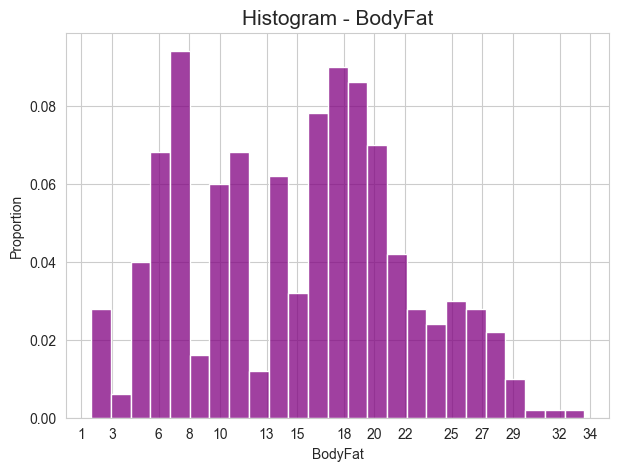

In [136]:
histogram(X=bodyfat_df[response], bins=25, color='purple', figsize=(7,5), random=True, n=500, seed=123, x_rotation=0) 

#### **Frequencies**

In [137]:
response_cat = quant_to_cat(bodyfat_df[response], rule='quartiles', n_intervals=7, random_seed=123)

In [138]:
freq_table(X=response_cat)

BodyFat: unique values,abs_freq,rel_freq,cum_abs_freq,cum_rel_freq
object,i64,f64,i64,f64
"(-inf, 0]",2,0.0003,2,0.000317
"(0, 10.1635]",1573,0.2497,1575,0.25
"(10.1635, 16.9893]",1575,0.25,3150,0.5
"(16.9893, 20.5085]",1574,0.2498,4724,0.749841
"(20.5085, 47.5]",1576,0.2502,6300,1.0


#### **Boxplot**

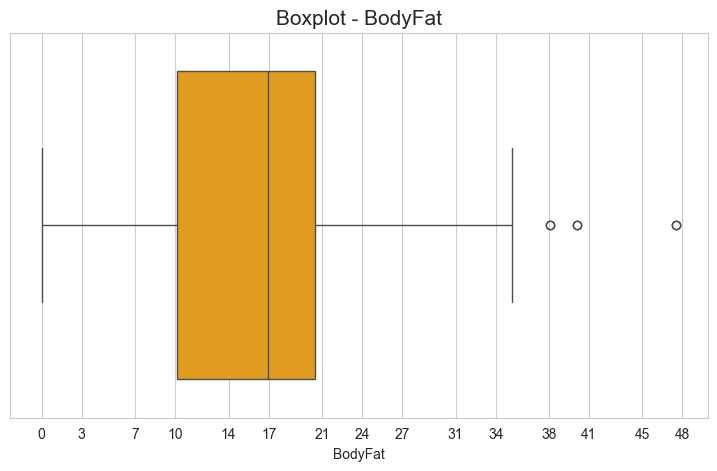

In [139]:
boxplot(X=bodyfat_df[response], color='orange', figsize=(9,5), n_xticks=15, x_rotation=0, statistics=False)

#### **ECDF-plot**

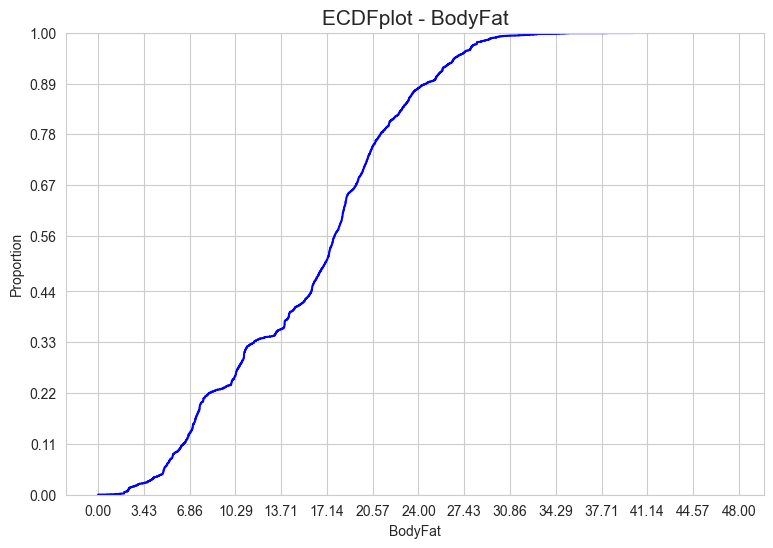

In [140]:
ecdfplot(X=bodyfat_df[response], color='blue', figsize=(9,6))

### **Relation between response and predictors**

In [141]:
quant_predictors = [x for x in quant_columns if x != response and x != 'Density']
cat_predictors = []

In [142]:
corr_matrix_response = corr_matrix(df=bodyfat_df, response=response, predictors=quant_predictors, method='pearson')

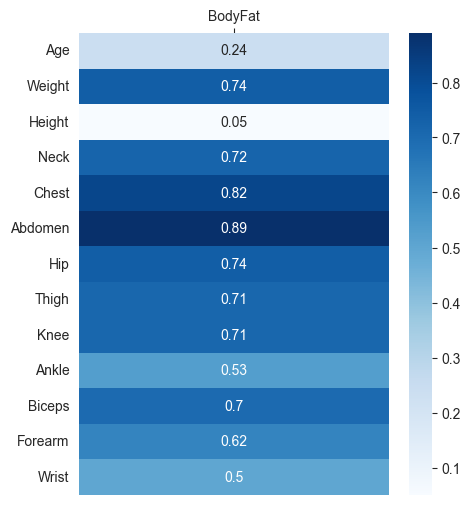

In [143]:
fig = plt.subplots(figsize=(5,6))
ax = sns.heatmap(corr_matrix_response, cmap="Blues", annot=True)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

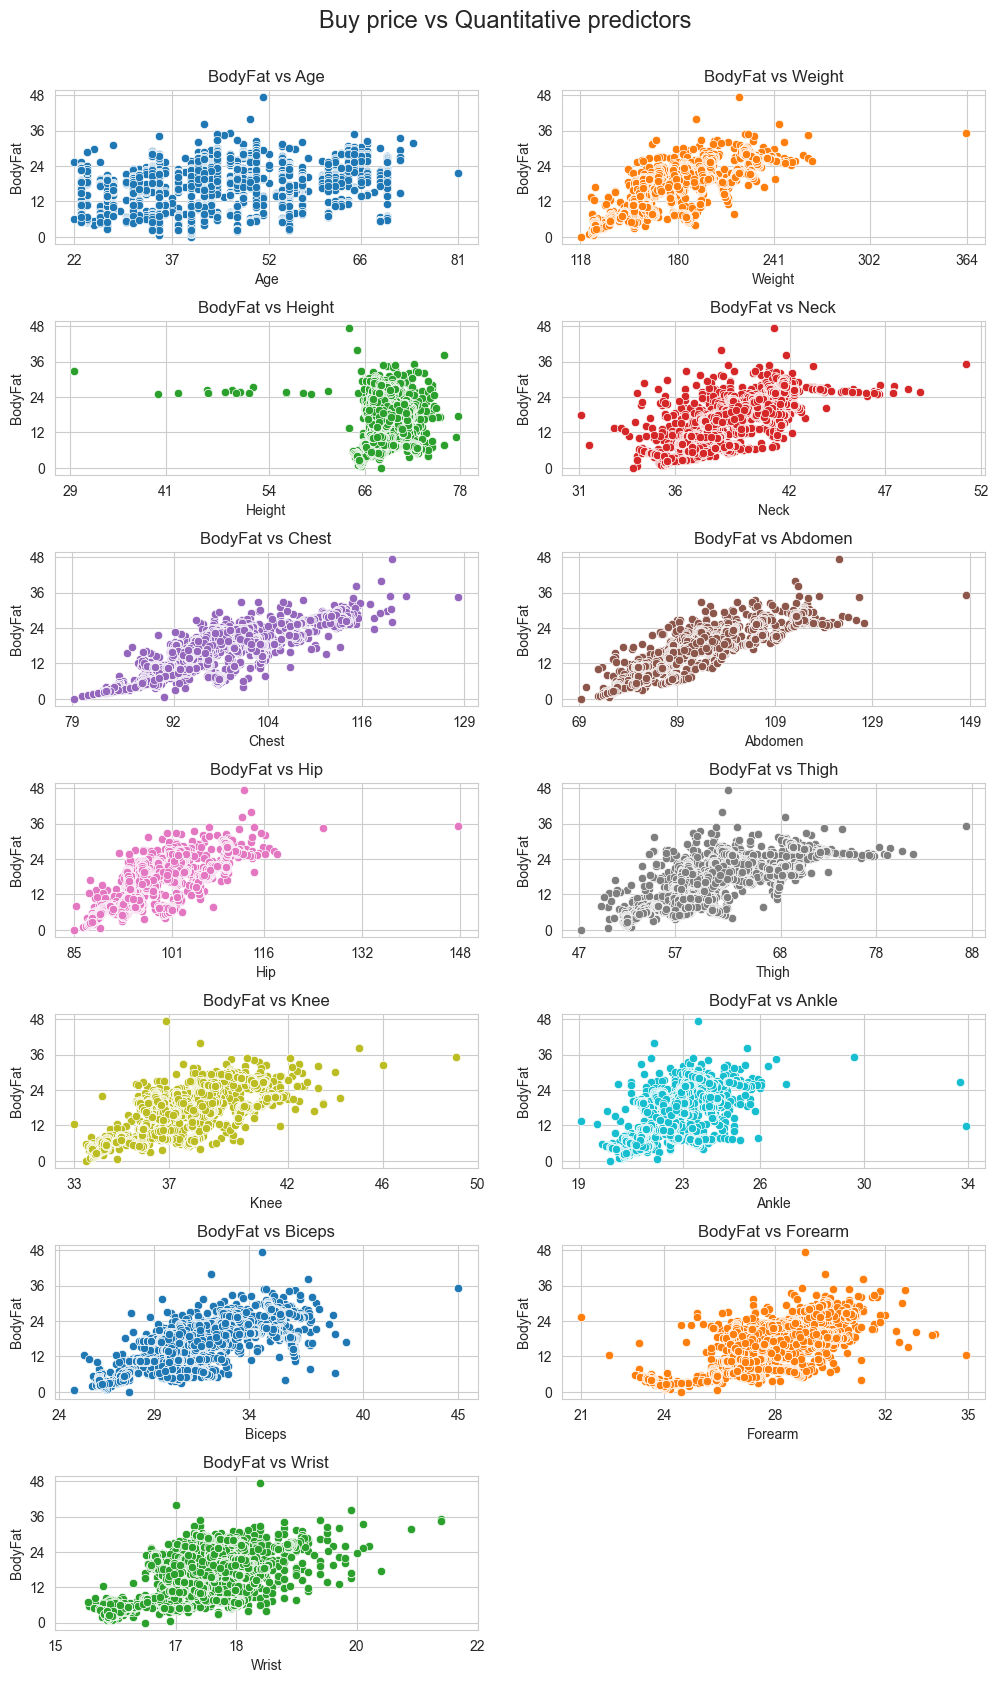

In [144]:
scatter_matrix(df=bodyfat_df, n_cols=2, tittle='Buy price vs Quantitative predictors', 
               figsize=(12,20), response=[response], predictors=quant_predictors,
               n_yticks=5, n_xticks=5, title_height=0.92, hspace=0.5, fontsize=17, )

## **Preprocessing Methods**



### **Imputers**



Methods for imputing missing values.

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$.

Assuming that $X_j$ has missing values $(\small{\Box})$. 

We define the variable $X_j$ without missing values:

$$X_j^* = \left(x_{ij} : x_{ij} \neq \small{\Box} \right)^\prime_{i=1,\dots,n}$$



#### **Simple imputer**

For $j=1,\dots , p$ and $i=1,\dots,n$ :

  - If $x_{ij} = \small{\Box}$, then:

    - If $X_j$ is quantitative:  
    
       $$x_{ij} \hspace{0.1cm}\leftarrow\hspace{0.1cm}  \overline{X}_j^* \hspace{0.12cm}\text{or}\hspace{0.12cm} Median(X_j^*)$$

    - If $X_j$ is categorical:  
    
       $$x_{ij} \hspace{0.1cm}\leftarrow\hspace{0.1cm}  Mode(X_j^*)$$



#### **KNN imputer**

The set with the indices of the $k$ nearest observations to $x_i$ is defined:

$$k_{id}(x_i) = \underset{h=1,..,n}{\text{arg}} \text{MinSort} (\lbrace \delta^*(x_i, x_h)  \rbrace_{h\neq i=1,\dots , n })[:k]$$

Then, the set of the $k$-nearest observations to $x_i$ can be defined easily:

$$knn(x_i) = \lbrace x_h : h\in k_{id}(x_i)\rbrace_{h=1,\dots,n}$$

where $\delta^*$ is the Euclidean NaN distance:

$$\delta^*(x_i, x_h) = \sqrt{p\cdot \text{mean}(d^*(x_i,x_h)^2)}$$

and $d*$ is the NaN difference between vectors: 

$$d*(x_i, x_h) = (x_{ij}- x_{hj} : x_{ij}\neq \small{\Box} , x_{ih}\neq \small{\Box})^\prime_{h=1,\dots,n}$$


We define the non-missing values $k$-nn version of $X_j$ as:

$$X_{j, knn(x_i)}^* = (x_{hj} : x_{hj}\neq \small{\Box}, \hspace{0.1cm} x_{j}\in knn(x_i))^\prime_{h=1,\dots,n}$$



The **imputation rule** is the following:

- If $x_{ij} = \small{\Box}$, then:

   - If $X_j$ is quantitative:  

    $$x_{ij} \hspace{0.1cm}\leftarrow\hspace{0.1cm}  \overline{X}^*_{j, knn(x_i)} \hspace{0.12cm}\text{or}\hspace{0.12cm} Median\big(X^*_{j, knn(x_i)}\big)$$

    - If $X_j$ is categorical:  
    
    $$x_{ij} \hspace{0.1cm}\leftarrow\hspace{0.1cm}  Mode\big(X_{j, knn(x_i)}^*\big)$$


#### **Iterative imputer**





For $j=1,\dots , p$ :

   1. If $X_j$ has missing values $\Rightarrow$ Continue.    
      Else $\Rightarrow$ jump to next $j$ iteration.

   2. Apply simple imputation on the rest of predictors  $Z=(X_h : h\neq j)_{h=1,\dots , p}$

   3. Train a model with $X_j$ as response and th rest of predictors $Z$ as predictors:

   $$M(\cdot | X=Z, Y=X_j)$$

   4. Predict the missing values of $X_j$ with $M$.

      For $i=1,\dots , n$:

         - If $x_{ij} = \small{\Box}$, then:

            - $\widehat{x}_{ij} = M(z_i | X=Z, Y=X_j)$

            - $x_{ij} \leftarrow \widehat{x}_{ij}$



##### **Visual explanation of Iterative imputer**

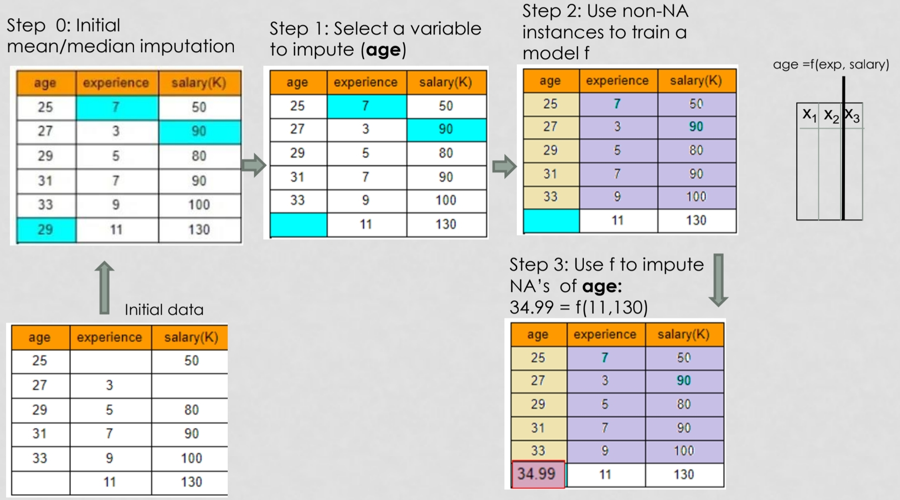

In [5]:
Image.open('images/itimp1.jpg').resize((900, 500))

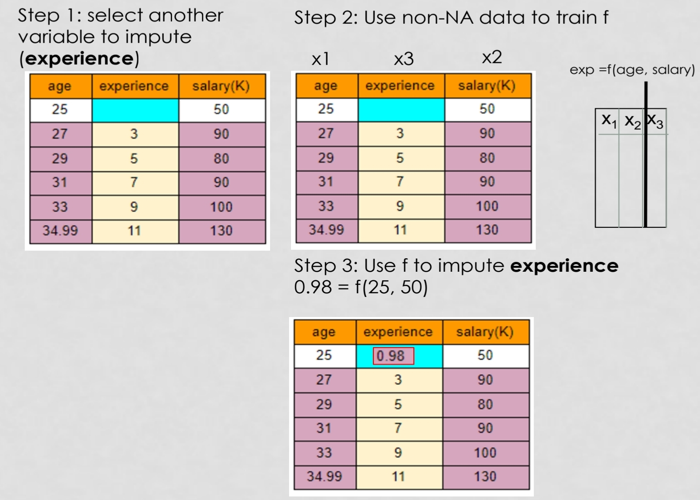

In [6]:
Image.open('images/itimp2.jpg').resize((700, 500))

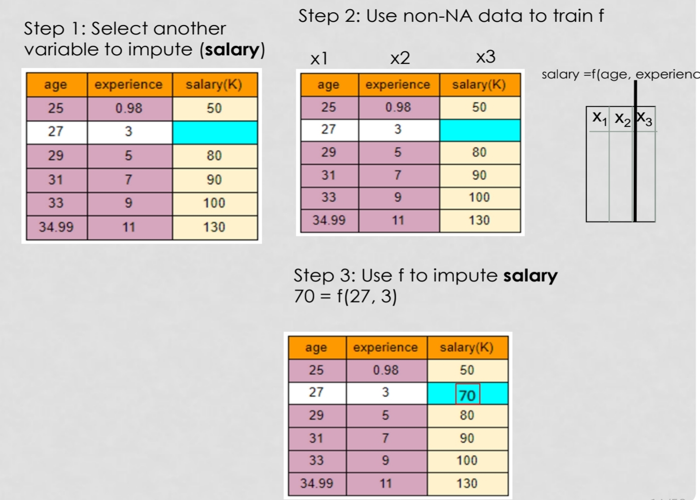

In [7]:
Image.open('images/itimp3.jpg').resize((700, 500))

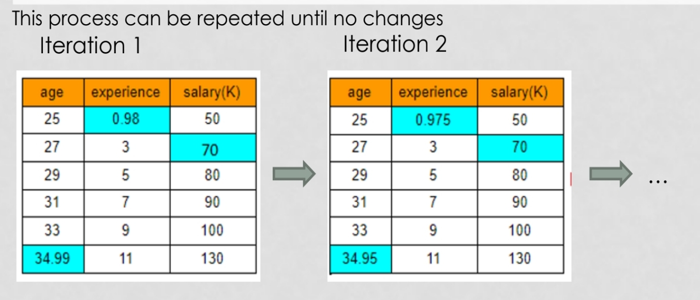

In [8]:
Image.open('images/itimp4.jpg').resize((700, 300))

### **Discretization**

Discretization (categorization) of quantitative variables.

Assuming that $X_j$ is quantitative, we want to discretize it in $b$ bins.


#### **Quantiles rule**

- Discretization intervals:

  $$I_{j-1} = (L_{j-1}, L_j], \quad j=1,\dots , b$$

  where: 

  $$L_{j} = Q_{j/b}(X_j)$$
  is the quantile $j/b$ of $X_j$.
  
  For example, if $b=4$, then:

  $$L_{0} = Q_{0}(X_j), \hspace{0.1cm} L_{1} = Q_{0.25}(X_j), \hspace{0.1cm} L_{2} = Q_{0.50}(X_j), \hspace{0.1cm} L_{3} = Q_{0.75}(X_j), \hspace{0.1cm} L_{4} = Q_{1}(X_j)$$

- Categorical version of $X_j$
  $$\widetilde{X}_j = (\widetilde{x}_{ij})_{i=1,\dots,n}^\prime$$

  where:
  $$\widetilde{x}_{ij} = \begin{cases} 0, \hspace{0.15cm} x_{ij}\in I_0 \\
                                       1, \hspace{0.15cm} x_{ij}\in I_1\\
                                       \dots \\
                                       b-1, \hspace{0.15cm} x_{ij} \in I_{b-1}
                         \end{cases}$$


#### **k-means rule**

- Apply $k$-means $(k=b)$ on $X_j$.

   - Clusters are predicted: 

    $$\widehat{y}_i \in \lbrace 0,\dots , b-1\rbrace \quad i=1,\dots, n$$

   - Cluster $h$ :

     $$C_h = (x_{ij} : \widehat{y}_i = h)_{i=1,\dots,n}$$

- Categorical version of $X_j$
  $$\widetilde{X}_j = (\widetilde{x}_{ij})_{i=1,\dots,n}^\prime$$

  where:
  $$\widetilde{x}_{ij} = \begin{cases} 0, \hspace{0.15cm} x_{ij}\in C_0 \\
                                       1, \hspace{0.15cm} x_{ij}\in C_1\\
                                       \dots \\
                                       b-1, \hspace{0.15cm} x_{ij} \in C_{b-1}
                         \end{cases}$$


### **Features Selection**


#### **F-value**

Assuming a quantitative response $Y$ and considering $X_j$ the predictor to analyze.

- $F$-value:

  $$F(X_j) \propto \dfrac{SS_{mean} - SS_{fit}}{SS_{fit}} = \dfrac{\text{ Variance of $Y$ explained by $X_j$ }}{\text{ Variance of $Y$ not explained by $X_j$ }}$$

  where:

  $$SS_{mean} = \sum_{i=1}^n (y_i - \overline{Y})^2$$

  $$SS_{fit} = \sum_{i=1}^n (y_i - \widehat{y}_i)^2$$

  $$\widehat{y}_i = M(x_{ij} | X_j, Y) = \widehat{\beta}_0 + \widehat{\beta}_j\cdot x_{ij}$$

- Feature selection rule:

    - Predictors are ranked by $F$-value in descending order.
   
    - The first $k$ are selected. 

- P-value

  Since $F(X_j)\sim F_{1,n-2}$, a p-value can be computed:

  $$\text{pvalue}(X_j) = P(F_{1, n-2} \geq F(X_j))$$
  
  This p-value can be interpreted like the probability of $X_j$ and $Y$ of being independent, namely, the probability of select $X_j$ wrongly.
  

#### **Fpr (False Positive Rate)**

For a fixed significance level $\alpha \in (0,1)$,

 - If $\text{pvalue}(X_j) \leq \alpha$ $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ Select $X_j$.

 - Else $\Rightarrow$ Not select $X_j$.

#### **Fwe (Family Wise Error)**

For a fixed significance level $\alpha \in (0,1)$,

 - If $\text{pvalue}(X_j) \leq \alpha/p$ $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ Select $X_j$.

 - Else $\Rightarrow$ Not select $X_j$.

#### **Fde (False Discovery Error)**

Let $P_j = \text{pvalue}(X_j)$.

For a fixed significance level $\alpha \in (0,1)$,

 - Sort $P_1,\dots , P_p$ in ascending order $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $P_{(1)}, \dots, P_{(p)}$

 - Find the largest $k$ such that $P_{(k)} \geq k\cdot \alpha/p$

 - Select the predictors associated to $P_{(1)}, \dots, P_{(k)}$ $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $X_{(1)},\dots , X_{(k)}$


#### **Best subset selection**

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$.

This algorithm consider a base model $M$ and compare all the possible combinations of predictors through the predictive performance of the base model with each one.

**Best subset selection algorithm:**
 
- We train all the possible models with  $1$ predictor, and select the one with less test prediction error computed by cross validation $\Rightarrow M_1^*$

- We train all the possible models with  $2$ predictor, and select the one with less test prediction error computed by cross validation $\Rightarrow M_2^*$  
   $\dots$ 

- We train all the possible models with  $p-1$ predictor, and select the one with less test prediction error computed by cross validation $\Rightarrow M_{p-1}^*$

- We train the full model $\Rightarrow M_{p}$

Among $M_1^*, M_2^*,\dots, M_{p-1}^*, M_p$ we select the one with less test prediction error, and its associated predictors are the ones selected.


#### **Backward selection**

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$.

This algorithm consider a base model $M$ and compare some combinations of predictors through the predictive performance of the base model with each one.

- We consider the full model $\Rightarrow M_{p}$
  
- We consider all the  models resulting from removing one predictor from the model $M_p$, and we select the one with less test prediction error by cross validation $\Rightarrow M_{p-1}^*$


- We consider all the   models resulting from removing one predictor from the model $M_{p-1}$, and we select the one with less test prediction error by cross validation $\Rightarrow M_{p-2}^*$
  
   $\dots$ 

- We consider all the   models resulting from removing one predictor from the model $M_2$, and we select the one with less test prediction error by cross validation $\Rightarrow M_{1}^*$

Among the models $M_1^*, M_2^*,\dots, M_{p-1}^*, M_p$ we select the one with less test prediction error, and its associated predictors are selected. 


#### **Forward selection**

This algorithm consider a base model $M$ and compare all the possible combinations of predictors through the predictive performance of the base model with each one.

This algorithm consider a base model and compare some combinations of predictors through the predictive performance of the base model with each one.

- We consider all the models with $1$ predictor,  and we select the one with less test prediction error by simple validation $\Rightarrow M_{1}^*$
  
- We consider all the  models resulting from adding one predictor to the model $M_1$, and we select the one with less test prediction error by simple validation $\Rightarrow M_{2}^*$


- We consider all the  models resulting from adding one predictor to the model $M_2$, and we select the one with less test prediction error by simple validation $\Rightarrow M_{3}^*$
  
   $\dots$ 

- We consider all the   models resulting from adding one predictor to the model $M_p-2$, and we select the one with less test prediction error by simple validation $\Rightarrow M_{p-1}^*$

- We consider the full  model $\Rightarrow M_{p}$

Among the models $M_1^*, M_2^*,\dots, M_{p-1}^*, M_p$ we select the one with less test prediction error, and its associated predictors are selected. 




## **Models**

### **Linear Regression**


#### **Assumptions**


We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$


- The model is defined as follows:

    $$y_i \hspace{0.1cm} =  \hspace{0.1cm} \beta_0 + x_i^\prime \cdot \beta \hspace{0.05cm}+\hspace{0.05cm}  \varepsilon_i$$

    Where:

    - $x_i = (x_{i1},\dots, x_{ip})^\prime \in \mathbb{R}^p$

    - $\beta = (\beta_1, \dots, \beta_p)^\prime  \in \mathbb{R}^p$

    - $\varepsilon_i$ is the residual term.

- The residual term has to fulfill the following properties:

    - $E[\varepsilon_i]=0$
    
    - $Var(\varepsilon_i)\hspace{0.05cm} =  \hspace{0.05cm}\sigma^2$
  
   - $\varepsilon_i \sim N(0,\sigma)$ 
  
   - $cov(\varepsilon_i , \varepsilon_j)\hspace{0.05cm} = \hspace{0.05cm}0  \hspace{0.1cm} ,  \hspace{0.1cm} \forall i\neq j$ 


-  Additional assumptions:

   -  $n  \hspace{0.1cm}> \hspace{0.1cm} p+1\hspace{0.3cm}$  $(\text{nº observations} \hspace{0.05cm}> \hspace{0.05cm} \text{nº of beta coefficients})$

   -  $Rg(X) \hspace{0.05cm}= \hspace{0.05cm}p+1$

   These additional assumptions are important because of the *dimensionality problem*.

#### **Coefficient estimation**

Parameters $\beta=(\beta_0, \beta_1, \dots, \beta_p)$ are estimated by Maximum Likelihood or Ordinary Least Square (OLS). Both are equivalent under the previous assumptions.

$$\widehat{\beta} \hspace{0.1cm} = \hspace{0.1cm} \text{arg}  \hspace{0.1cm}\underset{ \beta}{\text{Min}} \hspace{0.1cm}  \sum_{i=1}^{n} \hspace{0.07cm}(y_i - x_i^\prime \cdot \beta)^2$$

The solution to this problem is:

$$\widehat{\beta} \hspace{0.1cm} = \hspace{0.1cm} (X^\prime \cdot X)^{-1} \cdot X^\prime \cdot Y$$

Where:

- $X \leftarrow (1,X)$



#### **Predictions**

Once we have estimated the model parameters we can make predictions on the response using data of the predictors.

The prediction of the response for the value $x_i \in \mathbb{R}^p$  of the predictors is:

$$\widehat{y}_i \hspace{0.05cm}=\hspace{0.05cm} \widehat{\beta}_0 + x_i^\prime \cdot \widehat{\beta} $$

Note that $x_i$ may be any vector of $\mathbb{R}^p$.

#### **The Curse of Dimensionality**

- If the true relationship between the response variable and the predictors is approximately linear, the predictions obtained with the linear regression model will have a small bias. But if the relationship is not linear the bias will be large.

Suppose we are in the best case and the true relationship between the response and the predictors is approximately linear, then the predictions have little bias:


- If the size $n$ is noticeably larger than the number of predictors $p$, that is, $n>>p$, then the predictions obtained with the linear regression model will have little variance, therefore the model will have a good performance predicting out-of-sample observations, as their predictions have little bias and variance.

- If $n \approx p$, then the predictions obtained with the linear regression model will have a lot of variance, therefore the model will have a poor performance predicting observations outside the train sample, as its predictions have a lot of variance, despite that have little bias.


- If $n < p$, then the linear regression model cannot be estimated, since the ordinary least squares problem cannot be solved. This fact is known as the curse of dimensionality in linear regression.

### **Penalized Linear Regression**



To use penalized linear regression methods, the response and predicators must be **standardized** to have mean 0 and variance 1.

We standardize the available samples of the predictors $\hspace{0.01cm} \mathcal{X}_1,\dots,\mathcal{X}_p\hspace{0.01cm}$ and the response $\hspace{0.01cm} \mathcal {Y}$.


$$\widetilde{Y} = \dfrac{Y - \overline{Y}}{S_{Y}}  \hspace{0.3cm}\Rightarrow \hspace{0.3cm} \widetilde{y}_i = \dfrac{y_i - \overline{y}}{S_{Y}} \\[0.5cm]$$

$$\widetilde{X}_j = \dfrac{X_j - \overline{X}_j}{S_{X_j}}  \hspace{0.3cm}\Rightarrow \hspace{0.3cm} \widetilde{x}_{ij} = \dfrac{x_{ij} - \overline{X}_j}{S_{X_j}} \\$$ 

para $\hspace{0.1cm}j = 1,\dots,p $.


Donde:

$$\overline{Y} = \dfrac{1}{n} \sum_{i=1}^n y_i \hspace{0.15cm} , \hspace{0.45cm} \overline{X}_j = \dfrac{1}{n} \sum_{i=1}^n x_{ij} \\$$

$$S_{Y} = \sqrt{\sum_{i=1}^n (y_{i}- \overline{Y})^2}  \hspace{0.15cm} , \hspace{0.45cm} S_{X_j} = \sqrt{\sum_{i=1}^n (x_{ij}- \overline{X}_j)^2}$$



The reason we standardize the predictors and the response is that it is a way to make the beta coefficients dimensionless. 

The units of measurement of the beta coefficients depend on the units of measurement of the predictors and the response. If instead of considering the original predictors and response we consider their standardized versions, which are dimensionless, then the beta coefficients will also be dimensionless, and with it the estimates of these coefficients.

This is relevant because in classical linear regression, without scaling predictors or response, if we had  $\hspace{0.1cm}\widehat{\beta}_r > \widehat{\beta}_j\hspace{0.1cm}$ this could not be be interpreted as that the predictor $\hspace{0.1cm}\mathcal{X}_r\hspace{0.1cm}$ was more relevant to explain the response than the predictor $\hspace{0.1cm}\mathcal{X}_j\hspace {0.1cm}$, since the estimated coefficients are not directly comparable as they are not measured in the same units, unless the predictors in question are measured in the same units.

On the other hand, if the predictors and the response are standardized, that interpretation is valid, since the estimated betas are dimensionless, and therefore directly comparable.

Now, after standardization, estimated betas close to zero imply little relevance of the associated predictor coefficient to explain or predict the response. And given two different coefficients, if one is greater than the other, the predictor associated with the larger one is more relevant to explaining or predicting the response than the predictor associated with the lower coefficient.

**Penalized Least Squares**

The Penalized Linear Regression model are basically the Linear Regression model with the difference that the response and the predictors are standardized and the estimation of the beta coefficients is done by penalized ordinary least squares. Now we are going to present the three most popular: **Ridge**, **Lasso** and **ElasticNet**.

### **Ridge Regression**

#### **Assumptions**

Same as in the Linear Regression model, but considering the predictors and response standardized as above.

#### **Coefficient estimation**

Parameters $\beta=(\beta_0, \beta_1, \dots, \beta_p)$ are estimated by Maximum Likelihood or Ordinary Least Square (OLS). Both are equivalent under the previous assumptions.

$$\widehat{\beta} \hspace{0.1cm} = \hspace{0.1cm} \text{arg}  \hspace{0.1cm}\underset{ \beta}{\text{Min}} \hspace{0.1cm}  \sum_{i=1}^{n} \hspace{0.07cm}(\widetilde{y}_i - \widetilde{x}_i^\prime \cdot \beta)^2 + \lambda\cdot || \beta ||_2^2$$


Where:

- $\widetilde{X} \leftarrow (\mathbf{1},\widetilde{X}) \hspace{0.2cm}\Rightarrow\hspace{0.2cm} \widetilde{x}_i^ \prime \leftarrow (1,\widetilde{x}_i^\prime)$

- $\lambda \geq 0\hspace{0.02cm}$ is the penalization parameter. 

- $|| \beta ||_2^2 \hspace{0.05cm} = \hspace{0.05cm} \sum_{j=1}^p \hspace{0.02cm} \beta_j^2\hspace{0.08cm}$ is the L2 (euclidean) norm (up to squared), and is a measure of the size of the vector $\beta$.



The solution to this project is the following:


$$\widehat{\beta}\hspace{0.1cm}=\hspace{0.1cm} \left( \hspace{0.05cm} \widetilde{X}^\prime \cdot \widetilde{X} + \lambda \cdot \mathbb{I}_n \hspace{0.05cm} \right)^{-1} \cdot \widetilde{X}^\prime \cdot \widetilde{Y}$$

**Observations:**

- The expression $\hspace{0.05cm}\lambda \cdot | | \beta||^2_2\hspace{0.05cm}$ **penalizes** the size of the vector $\beta$.

    - The larger $\lambda$, the greater the penalty imposed on the size of the vector $\beta$ in the optimization problem.

- If $\lambda = 0$ the optimization problem is ordinary least squares (OLS), typical of the ordinary linear regression model. 

- If $\lambda$ is **very large** the solution to the problem $\widehat{\beta}$ will have a **size** (Euclidean norm) **very small**, that is, the estimated coefficients $\widehat{\beta}_1, \widehat{\beta}_2,\dots, \widehat{\beta}_p\hspace{0.05cm} \approx \hspace{0.05cm} 0\hspace{0.05cm}$ although all will be $\hspace{0.05cm}\ neq 0$  

- $\lambda \hspace{0.01cm}$ must be selected **a priori** from the solution of the Ridge optimization problem. It is a **hyper-parameter** of the Ridge linear regression algorithm.

#### **Predictions**

Once we have estimated the model parameters we can make predictions on the response using data of the predictors.

The prediction of the response for the value $x_i \in \mathbb{R}^p$  of the predictors is:

$$\widehat{\widetilde{y}}_i \hspace{0.05cm}=\hspace{0.05cm}  \widetilde{x}_i^\prime \cdot \widehat{\beta} $$

Note that $\widetilde{x}_i$ depends on $x_i$ and it may be any vector of $\mathbb{R}^p$.

If we want the predictions for the original response, we must destandardize the predictions by applying the inverse operation to that of standardizing, that is, multiplying by the standard deviation and adding the mean of the training response.

$$\widehat{\hspace{0.01cm} y \hspace{0.01cm}}_i \hspace{0.05cm} = \hspace{0.05cm} S_Y \cdot \widehat{\widetilde{y}}_i  + \overline{Y}$$

#### **Hyper-parameters**

- Penalization $\Rightarrow$ $\lambda =$ `alpha`

#### **Advantages of Ridge regression** 

- The predictions obtained with the linear regression algorithm by ordinary least squares are unbiased but have high variance, especially if $\hspace{0.015cm}p \approx n \hspace{0.015cm}$. Furthermore, if $\hspace{0.015cm}p>n\hspace{0.015cm}$ the algorithm cannot be estimated or trained by ordinary least squares.

- Ridge linear regression is based on the balance between bias and variance. It substantially reduces the variance of the predictions at the cost of slightly increasing their bias. Furthermore, even if $\hspace{0.015cm}p \approx n \hspace{0.015cm}$ or $\hspace{0.015cm} p>n\hspace{0.015cm}$ , Ridge regression can work well.


- As a conclusion to the previous point, if $\hspace{0.015cm}\lambda\hspace{0.015cm}$ is selected correctly, the mean square prediction error will be lower in the Ridge regression than in the ordinary least squares regression, which means leads to better predictive ability of Ridge over ordinary least squares.

#### **Disadvantages of Ridge Regression**

The Ridge regression method does not select predictors. That is, although the Ridge regression can bring the estimated betas closer to zero, it does not lead any of them to be exactly zero.

Therefore, Ridge regression will always generate a linear regression model that involves all the predictors initially considered.


Increasing $\hspace{0.01cm} \lambda \hspace{0.01cm}$ will tend to reduce the magnitudes of the beta coefficients, but will not result in the exclusion of any of the predictors.

Solution: **Lasso Regression**

### **Lasso Regression**

#### **Assumptions**

The same as in the Linear Regression model, but considering the predictors and response standardized as above.

#### **Coefficient estimation**

Parameters $\beta=(\beta_0, \beta_1, \dots, \beta_p)$ are estimated by Maximum Likelihood or Ordinary Least Square (OLS). Both are equivalent under the previous assumptions.

$$\widehat{\beta} \hspace{0.1cm} = \hspace{0.1cm} \text{arg}  \hspace{0.1cm}\underset{ \beta}{\text{Min}} \hspace{0.1cm}  \sum_{i=1}^{n} \hspace{0.07cm}(\widetilde{y}_i - \widetilde{x}_i^\prime \cdot \beta)^2 + \lambda\cdot || \beta ||_1$$


Where:

- $\widetilde{X} \leftarrow (\mathbf{1},\widetilde{X}) \hspace{0.2cm}\Rightarrow\hspace{0.2cm} \widetilde{x}_i^ \prime \leftarrow (1,\widetilde{x}_i^\prime)$

- $\lambda \geq 0\hspace{0.02cm}$ is the penalization parameter. 

- $|| \beta ||_1 \hspace{0.05cm} = \hspace{0.05cm} \sum_{j=1}^p \hspace{0.02cm} | \beta_j |\hspace{0.08cm}$ is the L1 (absolute) norm, and is a measure of the size of the vector $\beta$.



This problem has not a closed solution. So, it must to be solved by mean of numerical non-linear optimization algorithms such as (Quasi) Newton's or Gradient Descent methods.

**Observations:**

- The expression $\hspace{0.05cm}\lambda \cdot | | \beta||_1\hspace{0.05cm}$ **penalizes** the size of the vector $\beta$.

    - The larger $\lambda$, the greater the penalty imposed on the size of the vector $\beta$ in the optimization problem.

- If $\lambda = 0$ the optimization problem is ordinary least squares (OLS), typical of the ordinary linear regression model. 

- If $\lambda$ is **very large** the solution to the problem $\widehat{\beta}$ will have a **size** (absolute norm) **very small**, that is, the estimated coefficients $\widehat{\beta}_1, \widehat{\beta}_2,\dots, \widehat{\beta}_p\hspace{0.05cm} \approx \hspace{0.05cm} 0\hspace{0.05cm}$ although all will be $\hspace{0.05cm}\neq 0$  

- $\lambda \hspace{0.01cm}$ must be selected **a priori** from the solution of the Lasso optimization problem. It is a **hyper-parameter** of the Lasso linear regression algorithm.

#### **Predictions**

Once we have estimated the model parameters we can make predictions on the response using data of the predictors.

The prediction of the response for individuals with the value $x_i \in \mathbb{R}^p$  for the predictors is:

$$\widehat{\widetilde{y}}_i \hspace{0.05cm}=\hspace{0.05cm}  \widetilde{x}_i^\prime \cdot \widehat{\beta} $$

Note that $\widetilde{x}_i$ depends on $x_i$ and it may be any vector of $\mathbb{R}^p$.

If we want the predictions for the original response, we must destandardize the predictions by applying the inverse operation to that of standardizing, that is, multiplying by the standard deviation and adding the mean of the training response.

$$\widehat{\hspace{0.01cm} y \hspace{0.01cm}}_i \hspace{0.05cm} = \hspace{0.05cm} S_Y \cdot \widehat{\widetilde{y}}_i  + \overline{Y}$$

#### **Hyper-parameters**

- Penalization $\Rightarrow$ $\lambda =$ `alpha`

### **ElasticNet Regression**

#### **Assumptions**

The same as in the Linear Regression model, but considering the predictors and response standardized as above.

#### **Coefficient estimation**

Parameters $\beta=(\beta_0, \beta_1, \dots, \beta_p)$ are estimated by Maximum Likelihood or Ordinary Least Square (OLS). Both are equivalent under the previous assumptions.

$$\widehat{\beta} \hspace{0.1cm} = \hspace{0.1cm} \text{arg}  \hspace{0.1cm}\underset{ \beta}{\text{Min}} \hspace{0.1cm}  \sum_{i=1}^{n} \hspace{0.07cm}(\widetilde{y}_i - \widetilde{x}_i^\prime \cdot \beta)^2 + \alpha\cdot \lambda\cdot || \beta ||_1 + (1-\alpha)\cdot \lambda\cdot || \beta ||_2^2$$


Where:

- $\widetilde{X} \leftarrow (\mathbf{1},\widetilde{X}) \hspace{0.2cm}\Rightarrow\hspace{0.2cm} \widetilde{x}_i^ \prime \leftarrow (1,\widetilde{x}_i^\prime)$

- $\lambda \geq 0\hspace{0.02cm}$ is the penalization parameter. 



**Observations:**

- $\alpha=1 \Rightarrow$ Ridge Regression

- $\alpha=0 \Rightarrow$ Lasso Regression

- $\alpha\in (0,1) \Rightarrow$ ElasticNet Regression

#### **Predictions**

Once we have estimated the model parameters we can make predictions on the response using data of the predictors.

The prediction of the response for the value $x_i \in \mathbb{R}^p$  of the predictors is:

$$\widehat{\widetilde{y}}_i \hspace{0.05cm}=\hspace{0.05cm}  \widetilde{x}_i^\prime \cdot \widehat{\beta} $$

Note that $\widetilde{x}_i$ depends on $x_i$ and it may be any vector of $\mathbb{R}^p$.

If we want the predictions for the original response, we must destandardize the predictions by applying the inverse operation to that of standardizing, that is, multiplying by the standard deviation and adding the mean of the training response.

$$\widehat{\hspace{0.01cm} y \hspace{0.01cm}}_i \hspace{0.05cm} = \hspace{0.05cm} S_Y \cdot \widehat{\widetilde{y}}_i  + \overline{Y}$$

#### **Hyper-parameters**

- Ridge-Lasso trade-off $\Rightarrow$ $\alpha=$ `l1_ratio`

- Penalization $\Rightarrow$ $\lambda = $ `alpha`

### **KNN**

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$

The $k$-nearest neighbors as regression algorithm has the following steps:

- A distance $\delta$ between observations of $X$ is define.

- Given an observation $x_{i}=(x_{i1},\dots , x_{ip})\in\mathbb{R}^p$ of the predictors, the $\delta$ distance between this new observation and those of $X$ is computed, that is, $\delta(x_{i}, x_{h})$ is calculated for $h=1,\dots,n$.

- The $k$ nearest observation to $\mathbf{x}_{i}$, according to $\delta$ distance, are selected. 
  The set of them is denoted by $K(\mathbf{x}_{i})_\delta$ and is the set of the $k$-nearest neighbors of $x_{i}$ according to $\delta$.

- The **prediction** of the response for the value $x_i$ of the predictors is is the mean of the response for the $k$-nearest neighbors of $x_i$:
 
    $$\widehat{\hspace{0.01cm} y \hspace{0.01cm}}_i \hspace{0.05cm} = \hspace{0.05cm} \dfrac{\hspace{0.05cm}1\hspace{0.05cm}}{k} \cdot \sum_{ \hspace{0.05cm} h \hspace{0.05cm} \in \hspace{0.05cm} \Delta } \hspace{0.07cm} y_h $$

    where: 

    - $\Delta \hspace{0.02cm} = \hspace{0.02cm} \small{ \bigl\{ \hspace{0.02cm} h = 1,\dots,n \hspace{0.1cm} : \hspace{0.1cm}  x_h \in K(x_{i})_\delta \hspace{0.02cm} \bigr\} }\hspace{0.03cm}$ is the set of index of the observations of the predictors that belong to $K(x_{i})_\delta\hspace{0.02cm}$.

#### Hyper-parameters

- The number of neighbors $\Rightarrow$ $k =$ `n_neighbors`

- The distance (metric) $\Rightarrow$ $\delta = $ `metric`

### **Regression Trees**

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$

A graphical example of a regression tree is the following:

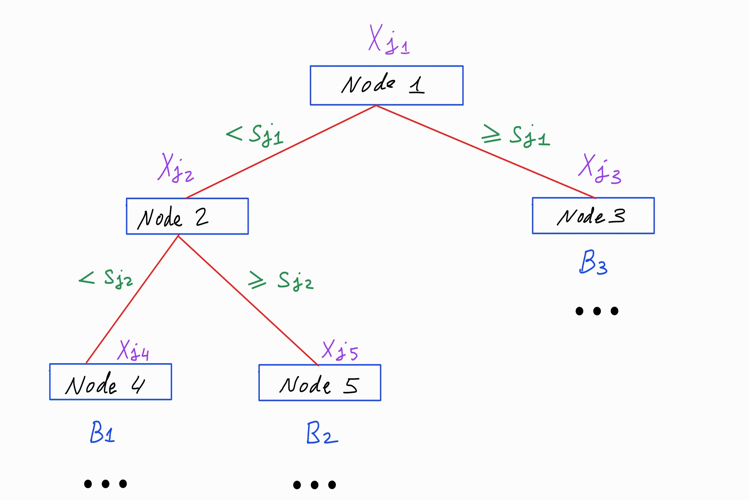

In [9]:
Image.open('images/tree.jpg').resize((750, 500))

Where:

- $B_j$ denotes the branches of the tree, and are the key elements of decision trees, which depends on the predictors $X_j$ and the thresholds $s_j$.

   - For example, in the above tree:

   $$B_1 = \lbrace x\in\mathbb{R}^p \hspace{0.1cm}: \hspace{0.1cm} x_{j_1} < s_{j_1} \hspace{0.07cm};\hspace{0.07cm} x_{j_2} < s_{j_2}   \rbrace  \\[0.6cm]$$

   $$B_2 = \lbrace x\in\mathbb{R}^p \hspace{0.1cm}: \hspace{0.1cm} x_{j_1} < s_{j_1} \hspace{0.07cm};\hspace{0.07cm} x_{j_2} \geq s_{j_2}   \rbrace \\[0.6cm]$$

   $$B_3 = \lbrace x\in\mathbb{R}^p \hspace{0.1cm}: \hspace{0.1cm} x_{j_1} \geq s_{j_1}  \rbrace  \\[0.6cm]$$

   $$\small{j_1, j_2 =1,\dots , p}$$

#### **Predictions**

Once we have estimated the model parameters we can make predictions on the response using data of the predictors.

The prediction of the response for the value $x_i \in \mathbb{R}^p$  of the predictors is:

- If $x_i\in B_j$, then:

    $$\widehat{\hspace{0.01cm} y \hspace{0.01cm}}_i \hspace{0.05cm}=\hspace{0.05cm}  \overline{Y}_{B_j} \hspace{0.05cm}=\hspace{0.05cm}  \small{\frac{1}{\# B_j}} \sum_{\substack{i=1 \\ x_i \in B_j}}^n y_i$$

Note that $x_i$ may be any vector of $\mathbb{R}^p$.

#### **Branches definition**

$$B_1, \dots, B_m \hspace{0.08cm}=\hspace{0.08cm} \text{arg}  \hspace{0.1cm}\underset{ B_1, .., B_m}{\text{Min}} \hspace{0.08cm} \sum_{j=1}^m RSS(B_j)$$

Where: 

$$RSS(B_j) = \sum_{\substack{i=1 \\ x_i \in B_j}}^n (y_i - \overline{Y}_{B_j})^2$$

is the train error in the branch $B_j$.

How to solve this optimization problem? $\Rightarrow$ **Recursive binary partition algorithm**

#### **Recursive binary partition algorithm**

The problem is solved sequentially (recursive), starting with the node 1 problem, then the node 2 (given the results of the above node problem (node 1)), and so on. Each node problem only consider two branches (binary), which depends on the results of the above nodes problems.

We are not going to go deeper into the details for the shake of brevity.

#### **Hyper-parameters**

The most important hyper-parameters (but not the only ones) are the following:

- `max_depth`: the maximum size tolerated for any branch. The size of a branch is its number of nodes.

- `min_samples_split`: number of training observations that has to contain a branch to split its terminal node. If it contains less than this min the terminal node is not split and the branch stop growing.

- `min_samples_leaf`: number of training obs that the new two branches created after splitting a terminal node have to contain to keep/consider that split.

If one of these two new branches contain less than that min, the split is not keep and the initial branch stop growing.

In this last point is important to notice that when a node is split two new branches appear, since branches are defined by a set of conditions and when a node is splitted two new sets of condition appear.

These hyper-parameters control the size of the tree, and serve as stopping criteria for branch growth.

They are applied sequentially.

Focus in a certain branch:

1. If its size is greater than max depth, its terminal node is not splitted.
Else $\Rightarrow$ 2.

2. If the branch contains less training obs than min samples split, its terminal node is not splitted.
Else $\Rightarrow$ 3.

3. If the num of train obs that one (or both) of the two new branches created after splitting its terminal node is lower than min samples leaf, that split is not considered.
Else $\Rightarrow$ split its terminal node.

### **Ensembles**

Model that aggregate other models (base models) to construct another model (meta-model).

#### **Bagging**

We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$

The bagging algorithm has the following steps:

- $B$ bootstrap samples $(X_1,Y_1),\dots, (X_B,Y_B)$ are extracted from $(X, Y)$, with a certain size $n_b\in \lbrace 1,\dots n\rbrace$ and number of predictors $p_b\in \lbrace 1,\dots p\rbrace$, the same for all of them.

- For $b=1,\dots , B$:

    - The base model $M$ is trained with $(X_b,Y_b)$ $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $\widetilde{M}_b= M_b(\cdot | X_b,Y_b)$

The prediction of the response for a given value $x_i \in \mathbb{R}^p$ of the predictors is:

$$\widehat{\hspace{0.03cm} y \hspace{0.03cm}} \hspace{0.05cm} = \hspace{0.05cm} \frac{1}{B} \sum_{b=1}^B \widehat{\hspace{0.03cm} y\hspace{0.03cm}}_i^{(b)}$$

Where $\widehat{\hspace{0.03cm} y\hspace{0.03cm}}_i^{(b)}= M_b(x_i | X_b,Y_b)$, namely, is the prediction made by $\widetilde{M}_b$ for $x_i$.

##### **Hyper-parameters**

- $B =$ `n_estimators`

- $n_b = $ `max_samples`

- $p_b =$ `max_features`

#### **Random Forest**





We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$

The Random Forest algorithm has the following steps:

- $B$ bootstrap samples $(X_1,Y_1),\dots, (X_B,Y_B)$ are extracted from $(X, Y)$, with a certain size $n_b\in \lbrace 1,\dots n\rbrace$ and number of predictors $p_b\in \lbrace 1,\dots p\rbrace$, the same for all of them.

- For $b=1,\dots , B$:

    - The **tree** base model $M$ is trained with $(X_b,Y_b)$ $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $\widetilde{M}_b= M_b(\cdot | X_b,Y_b)$

       - Where tree model $M$ has the following particularity: 
       
         1. In each node problem only consider $p_{\tiny{RF}} < p$ predictors selected randomly. 
         
         
        This random selection depend on bootstrap sample, so, it depends on $b$, and, therefore, the model as well.

The prediction of the response for a given value $x_i\in \mathbb{R}^p$ of the predictors is:

$$\widehat{\hspace{0.03cm} y \hspace{0.03cm}} \hspace{0.05cm} = \hspace{0.05cm} \frac{1}{B} \sum_{b=1}^B \widehat{\hspace{0.03cm} y\hspace{0.03cm}}_i^{(b)}$$

Where $\widehat{\hspace{0.03cm} y\hspace{0.03cm}}_i^{(b)}= M_b(x_i | X_b,Y_b)$, namely, is the prediction made by $\widetilde{M}_b$ for $x_i$.

##### **Hyper-parameters**

- $B =$ `n_estimators`

- $p_{\tiny{RF}} =$ `max_features`

#### **Extra-Trees**




We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$

The Extra-Trees (Extremely Randomized Trees) algorithm has the following steps:

- The whole data $(X,Y)$ will be used to train each base model (bootstrap sampling is not used).

- For $b=1,\dots , B$: 

    - The **tree** base model $M_b$ is trained with $(X,Y)$ $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $\widetilde{M}_b = M_b(\cdot | X,Y)$

       - Where the tree model $M_b$ has the following particularities: 
       
          1. In each node problem only consider $p_{\tiny{ET}} < p$ predictors selected randomly. 

          2. The threshold associated to each selected predictor is chosen randomly. 
          
          Both random selections depend on bootstrap sample, so, it depends on $b$, and, therefore, the model as well.

The prediction of the response for a given value $x_i\in \mathbb{R}^p$ of the predictors is:

$$\widehat{\hspace{0.03cm} y \hspace{0.03cm}}_i \hspace{0.05cm} = \hspace{0.05cm} \frac{1}{B} \sum_{b=1}^B \widehat{\hspace{0.03cm} y\hspace{0.03cm}}_i^{(b)}$$

Where $\widehat{\hspace{0.03cm} y\hspace{0.03cm}}_i^{(b)} = M_b(x_i | X,Y)$, namely, the prediction made by $\widetilde{M}_b$ for $x_i$.

##### **Hyper-parameters**

- $B =$ `n_estimators`

- $p_{\tiny{ET}} =$ `max_features`

#### **Boosting**





#### **Stacking**




We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$.

**Cross Validation Predictions**

An important concept in stacking is Cross Validation ($k$-Fold) predictions. First we will explain it.

$(X,Y)$ are divided in $k$ Folds:


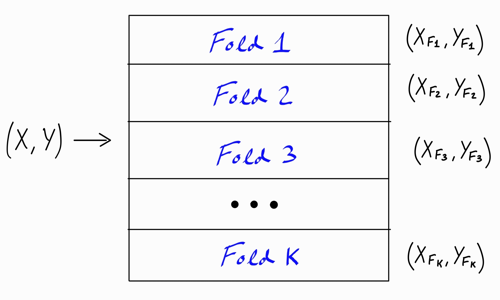

In [10]:
Image.open('images/cv_predictions.jpg').resize((500, 300))



- $M$ cross validation predictions for the $j$-th Fold $\hspace{0.1cm}\Rightarrow \hspace{0.1cm} \widehat{Y}_{F_j} = M( X_{F_j} | X_{F_{\neq j}}, Y_{F_{\neq j}})$

   - $X_{F_{\neq j}} = (X_{F_h} : h\neq j=1,\dots ,k)\quad$ (concatenation by rows)

   - $Y_{F_{\neq j}} = (Y_{F_h} : h\neq j=1,\dots ,k)\quad$ (concatenation by rows)

- $M$ cross validation predictions $\hspace{0.1cm}\Rightarrow \hspace{0.1cm} \widehat{Y}_{CV} = \left(\widehat{Y}_{F_1},\dots ,  \widehat{Y}_{F_k}\right)$

Note that cross validation predictions are testing predictions since the model is trained with different observations to the ones predicted.

**Stacking algorithm**

- Base models: $M_1,\dots, M_h$

- Meta models: $M_*$

- Compute Cross Validation Predictions of the response for each base model, using $(X,Y)$.

   $$\widehat{Y}_{CV}(M_1),\dots ,\widehat{Y}_{CV}(M_h)$$

- Stacking data:

   $$\left(X_{ST}, Y\right) = \big(\hspace{0.05cm}\underset{\text{Stacking predictors}}{\underbrace{\widehat{Y}_{CV}(M_1),\dots ,\widehat{Y}_{CV}(M_h)}}, Y \hspace{0.05cm}\big)$$

- Train meta-model $M_*$ with Stacking data $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $\widetilde{M}_* = M_*(\cdot | X_{ST}, Y)$

- Train base-models  $M_1,\dots, M_h$ with original data $\hspace{0.1cm}\Rightarrow\hspace{0.1cm}$ $\widetilde{M}_j = M_j(\cdot | X, Y), \quad j=1,\dots,h$

- The prediction of the response for a given value $x_i\in \mathbb{R}^p$ of the predictors is:

   $$M_*(x_i^{\tiny{ST}}| X_{ST}, Y)$$

   where:

    - $x_i^{\tiny{ST}} = (\widehat{y}_{i1}, \dots, \widehat{y}_{ih})\in \mathbb{R}^h$ is the Stacking version of $x_i\in \mathbb{R}^p$.

    - $\widehat{y}_{ij} = M_j(x_i | X,Y)$ is the prediction made by the $j$-th base model for $x_i$, for $j=1,\dots, h$.

    - $x_i$ may be any vector of $\mathbb{R}^p$.



## **Inner-Outer Evaluation**

### **Validation** 

Methods to validate predictive supervised algorithms.


We have a response variable $\mathcal{Y}$ and $p$ predictors $\mathcal{X} = (\mathcal{X}_1,\dots, \mathcal{X}_p).$ 

We also have an $n$ size sample of this variables: $\hspace{0.1cm} Y\in \mathbb{R}^n, \hspace{0.2cm} X=(X_1,\dots , X_p)\in \mathbb{R}^{n\times p}$.


#### **Simple Validation**



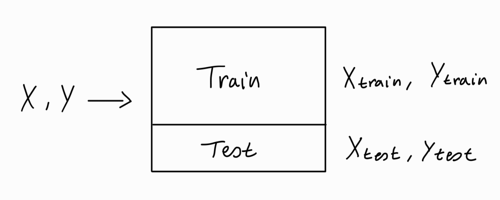

In [11]:
Image.open('images/sv.jpg').resize((500, 200))

- Usual train size: $\hspace{0.1cm}60\%-80\%$

- Usual test size: $\hspace{0.1cm}30\%-20\%$

The steps to compute a validation metric $\phi$ by simple validation are the following:

- $X,Y$ $\Rightarrow$ $\begin{cases}  X_{train} , Y_{train} \\ X_{test}, Y_{test} \end{cases}$

- $\widehat{Y}_{test} = M(X_{test} | X_{train}, Y_{train})$

- Compute the validation metric: 

   $$\phi_{sv} = \phi(\widehat{Y}_{test}, Y_{test})$$


Examples of validation metrics (in regression) are:

- MAE: 

   $$\phi(\widehat{y}_i , y_i) = \dfrac{1}{n} \sum_{i=1}^n |\widehat{y}_i - y_i|$$

- MSE:

   $$\phi(\widehat{y}_i , y_i) = \dfrac{1}{n} \sum_{i=1}^n (\widehat{y}_i - y_i)^2$$



#### **k-Fold Cross Validation**



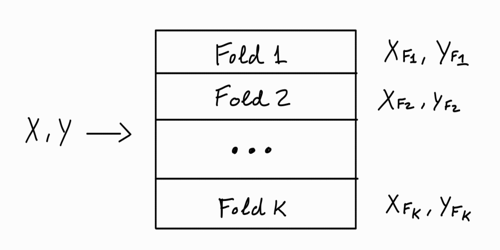

In [12]:
Image.open('images/kfold.jpg').resize((500, 250))

The steps to compute a validation metric $\phi$ by simple validation are the following:

- $X,Y$ $\Rightarrow$ $\begin{cases}  X_{F_1} , Y_{F_1} \\ \dots \\ X_{F_k}, Y_{F_k} \end{cases}$

- For $j=1,\dots ,k$:
   
    - $\widehat{Y}_{F_j} = M(X_{F_j} | X_{F_{\neq j}}, Y_{F_{\neq j}})$

    - $\phi_{F_j} = \phi(\widehat{Y}_{F_j}, Y_{F_j})$

- Compute the validation metric: 

   $$\phi_{cv} = \dfrac{1}{k} \sum_{j=1}^{k}\phi_{F_j}$$


### **Evaluation** 

#### **Evaluation types**

- **Inner evaluation:** compare alternatives (pipelines) 

     - **HPO**: select the best pipeline for each model

     - **Best model**: select the best pipeline overall

- **Outer evaluation:** estimation of future performance


#### **Evaluation schemas**

- **Simple evaluation:** 

     - **Outer**: simple validation

     - **Inner**: simple validation or k-Fold

- **Semi-Nested evaluation:** 

    - **Outer**: k-Fold

    - **Inner**: simple validation

- **Nested evaluation:**

   - **Outer**: k-Fold

   - **Inner**: k-Fold

## **Machine Learning Workflow**

- Response and Predictors definition 

- Preprocessing (transformers): 
    - Missing value imputation: simple imputer, knn imputer, iterative imputer.
    - Scaling data: standard scaler, not scale.
    - Discretization: quantiles discretizer, kmeans discretizer, not discretize.
    - Feature selection: Fdr, Fpr, Forward, Backward, not feature selection.

- Models (estimators):
   - KNN
   - Linear Regression
   - Ridge Regression
   - Lasso Regression
   - ElasticNet Regression
   - Decision Trees
   - Extra Trees
   - Random Forest
   - Histogram Gradient Boosting
   - XGBoost
   - SVM (linear)
   - Neural Network (Multi-Layer Perceptron)

- Inner-Outer Evaluation schema: 
    -  Nested Cross Validation (Outer: k-Fold ; Inner: k-Fold)

-  HPO (inner evaluation)
   - Hyper-parameter optimization: selecting the best alternative for each model.

- Model Selection (inner evaluation)
   - Selecting the best model overall.

- Predictive analysis 
    - Estimation of future performance of the best model.
    - Predictive intervals for the best model.

- Inference with the best linear regression model
    - Coefficients interpretation.
    - Significance analysis.

### **Response and predictors definition**

The aim of our project is to estimate the percentage of body fat in a accurate way without the need to use `Density`, since in practice computing `Density` is highly demanding. So, we will no use `Density` as predictor. And our response variable will be `BodyFat`.


In [145]:
response = 'BodyFat'
predictors = [x for x in bodyfat_df.columns if x not in ['BodyFat', 'Density']]

# Since sklearn works better with Pandas, we are going define X and Y as Pandas objects.
X = bodyfat_df[predictors].to_pandas()
Y = bodyfat_df[response].to_pandas()

In [146]:
predictors

['Age',
 'Weight',
 'Height',
 'Neck',
 'Chest',
 'Abdomen',
 'Hip',
 'Thigh',
 'Knee',
 'Ankle',
 'Biceps',
 'Forearm',
 'Wrist']

### **HPO**

#### **Pipelines definition**

Defining a preprocessign (transformers) pipeline for the quantitative variables an another for the categoricals.

Despite our data set hos not categorical variables we are going to consider `Age` as categorical, since we want to apply a special preprocessing pipeline to this variable which include a discretizer (we want to test the alternative of transforming `Age` in a categorical variable).

In [147]:
quant_predictors = [x for x in predictors if x != 'Age']
cat_predictors = ['Age']

quant_pipeline = Pipeline([
    ('imputer', imputer()),
    ('scaler', scaler())
    ])

cat_pipeline = Pipeline([
    ('imputer', imputer()),
    ('discretizer', discretizer())
    ])

quant_cat_processing = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                       ('cat', cat_pipeline, cat_predictors)])

Defining a pipeline (transformers + estimators) for each considered model (estimator).

In [148]:
pipelines = {}

pipelines['knn'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('knn', KNeighborsRegressor()) 
    ])

pipelines['linear_regression'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('linear_regression', LinearRegression()) 
    ])

pipelines['ridge_regression'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('ridge', Ridge()) 
    ])

pipelines['lasso_regression'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('lasso', Lasso()) 
    ])

pipelines['elastic_net_regression'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('elastic_net', ElasticNet()) 
    ])

pipelines['trees'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('trees', DecisionTreeRegressor(criterion='squared_error', random_state=123)) 
    ])

pipelines['extra_trees'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('extra_trees', ExtraTreesRegressor(criterion='squared_error', random_state=123))
    ])

pipelines['RF'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('RF', RandomForestRegressor(criterion='squared_error', random_state=123))
    ])

pipelines['histGB'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('histGB', HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.1, random_state=123)) 
    ])

pipelines['XGB'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('XGB', XGBRegressor(objective='reg:squarederror', booster='gbtree', random_state=123))
    ])

pipelines['linear_SVM'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('linear_SVM', LinearSVR(loss='epsilon_insensitive', random_state=123))
    ])

pipelines['MLP_NN'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('MLP_NN', MLPRegressor(random_state=123))
    ])

pipelines['bagging_knn'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('bagging_knn', BaggingRegressor(estimator=KNeighborsRegressor(), random_state=123))
    ])

pipelines['boosting_trees'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('boosting_trees', GradientBoostingRegressor(random_state=123))
    ])

#####################################################################

base_models = [
    ('knn', KNeighborsRegressor()),
    ('tree', DecisionTreeRegressor())
]

pipelines['stacking'] = Pipeline([
    ('preprocessing', quant_cat_processing),
    ('features_selector', features_selector()),
    ('stacking', StackingRegressor(estimators=base_models, final_estimator=LinearRegression(), cv=5))
    ])

We can plot the pipeline of a certain model to understand it better.

In [149]:
pipelines['knn']

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant',
                                                  Pipeline(steps=[('imputer',
                                                                   imputer()),
                                                                  ('scaler',
                                                                   scaler())]),
                                                  ['Weight', 'Height', 'Neck',
                                                   'Chest', 'Abdomen', 'Hip',
                                                   'Thigh', 'Knee', 'Ankle',
                                                   'Biceps', 'Forearm',
                                                   'Wrist']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   imputer()),
                                                                  ('discretizer',
                                                                   discretizer())]),
                                                  ['Age'])])),
                ('features_selector', features_selector()),
                ('knn', KNeighborsRegressor())])

#### **Grids for HPO**

Despite our evaluation function allow to use grid and random search and `Optuna` for making the aearch of hyper-parameter, we will only use `Optuna`, for the following reasons:

- Based on Bayesian search.

- Allow to define dynamical (conditioned) grids.
- Very fast (even more than the `sklearn` implementation of random search).

Here we define the grids for both the preprocessing steps of the pipelines and the models.

In [150]:
def common_param_grid(trial, features_selector='all'):

    param_grid = {
        'preprocessing__quant__imputer__method': trial.suggest_categorical('preprocessing__quant__imputer__method', ['simple_median', 'iterative_median', 'knn']),
        'preprocessing__cat__imputer__method': trial.suggest_categorical('preprocessing__cat__imputer__method', ['simple_median', 'iterative_median', 'knn']),
        'preprocessing__quant__scaler__apply': trial.suggest_categorical('preprocessing__quant__scaler__apply', [True, False]),
        'preprocessing__cat__discretizer__apply': trial.suggest_categorical('preprocessing__cat__discretizer__apply', [True, False])
    }

    if features_selector == 'backward_linear_reg' :
        param_grid.update({
        'features_selector__method': trial.suggest_categorical('features_selector__method', ['backward_linear_regression'])      
        })
        
    elif features_selector == 'forward_linear_reg' :
        param_grid.update({
        'features_selector__method': trial.suggest_categorical('features_selector__method', ['forward_linear_regression'])      
        })

    elif features_selector == 'all' :
        param_grid.update({
        'features_selector__method': trial.suggest_categorical('features_selector__method', ['not_select', 'Fpr', 'Fdr', 
                                                                                             'backward_linear_regression', 
                                                                                             'forward_linear_regression',
                                                                                             'backward_knn', 'forward_knn'])      
        })


    # Conditioned grids
    if  param_grid['preprocessing__quant__imputer__method'] == 'knn':
        quant_imputer_n_neighbors = trial.suggest_int('preprocessing__quant__imputer__n_neighbors', 1, 4)
        param_grid.update({'preprocessing__quant__imputer__n_neighbors': quant_imputer_n_neighbors})

    if  param_grid['preprocessing__cat__imputer__method'] == 'knn':
        param_grid.update({'preprocessing__cat__imputer__n_neighbors': trial.suggest_int('preprocessing__cat__imputer__n_neighbors', 1, 4)})

    if 'iterative' in param_grid['preprocessing__quant__imputer__method']:
        quant_imputer_n_nearest_features = trial.suggest_int('preprocessing__quant__imputer__n_nearest_features', 3, 7)
        param_grid.update({'preprocessing__quant__imputer__n_nearest_features': quant_imputer_n_nearest_features})

    if 'iterative' in param_grid['preprocessing__cat__imputer__method']:
        param_grid.update({'preprocessing__cat__imputer__n_nearest_features': trial.suggest_int('preprocessing__cat__imputer__n_nearest_features', 3, 7)})

    if param_grid['preprocessing__cat__discretizer__apply'] == True:
        param_grid.update({'preprocessing__cat__discretizer__n_bins': trial.suggest_int('preprocessing__cat__discretizer__n_bins', 2, 5),
                           'preprocessing__cat__discretizer__strategy': trial.suggest_categorical('preprocessing__cat__discretizer__strategy', ['quantile', 'kmeans'])})

    return param_grid

In [151]:
# Grid for knn
def param_grid_knn_optuna(trial):

    param_grid = common_param_grid(trial)

    # NoT conditioned grid for KNN
    param_grid.update({
        'knn__n_neighbors': trial.suggest_int('knn__n_neighbors', 1, 25),
        'knn__metric': trial.suggest_categorical('knn__metric', ['cosine', 'minkowski', 'cityblock'])
    })

    # Conditioned grid for KNN
    if param_grid['knn__metric'] == 'minkowski':
        param_grid['knn__p'] = trial.suggest_int('knn__p', 1, 4)

    return param_grid

In [152]:
# Grid for bagging knn
def param_grid_bagging_knn_optuna(trial):

    param_grid = common_param_grid(trial)

    # Not conditioned grid for bagging KNN
    param_grid.update({
        'bagging_knn__estimator__n_neighbors': trial.suggest_int('bagging_knn__estimator__n_neighbors', 1, 25),
        'bagging_knn__estimator__metric': trial.suggest_categorical('bagging_knn__estimator__metric', ['cosine', 'minkowski', 'cityblock']),
        'bagging_knn__n_estimators': trial.suggest_categorical('bagging_knn__n_estimators', [10, 20, 30, 50, 70, 100]),
        'bagging_knn__max_features': trial.suggest_categorical('bagging_knn__max_features', [0.70, 0.80, 0.90, 1.0]),
        'bagging_knn__max_samples': trial.suggest_categorical('bagging_knn__max_samples', [0.70, 0.80, 0.90, 1.0])

    })

    # Conditioned grid for bagging KNN
    if param_grid['bagging_knn__estimator__metric'] == 'minkowski':
        param_grid['bagging_knn__estimator__p'] = trial.suggest_int('bagging_knn__estimator__p', 1, 4)

    return param_grid

In [153]:
# Grid for linear regression
def param_grid_linear_regression_optuna(trial):

    param_grid = common_param_grid(trial)

    return param_grid

In [154]:
# Grid for backward linear regression
def param_grid_linear_regression_backward_optuna(trial):

    param_grid = common_param_grid(trial, features_selector='backward_linear_reg')

    return param_grid

In [155]:
# Grid for forward linear regression
def param_grid_linear_regression_forward_optuna(trial):

    param_grid = common_param_grid(trial, features_selector='forward_linear_reg')

    return param_grid

In [156]:
# Grid for Ridge
def param_grid_ridge_optuna(trial):

    param_grid = common_param_grid(trial, features_selector=False)

    # Specific logic for Ridge
    param_grid.update({
        'ridge__alpha': trial.suggest_float('ridge__alpha', 0.1, 10, log=True)
    })

    return param_grid

In [157]:
# Grid for Lasso
def param_grid_lasso_optuna(trial):

    param_grid = common_param_grid(trial, features_selector=False)

    # Specific logic for Lasso
    param_grid.update({
        'lasso__alpha': trial.suggest_float('lasso__alpha', 0.1, 10, log=True),
    })

    return param_grid

In [158]:
# Grid for ElasticNet
def param_grid_elastic_net_optuna(trial):

    param_grid = common_param_grid(trial, features_selector=False)

    # Specific logic for Lasso
    param_grid.update({
        'elastic_net__alpha': trial.suggest_float('elastic_net__alpha', 0.1, 10, log=True),
        'elastic_net__l1_ratio': trial.suggest_float('elastic_net__l1_ratio', 0.1, 0.9, step=0.02)
    })

    return param_grid

In [159]:
# Grid for trees
def param_grid_trees_optuna(trial):

    param_grid = common_param_grid(trial)

    param_grid.update({
        'trees__max_depth': trial.suggest_categorical('trees__max_depth', [None, 2, 5, 7, 10, 20, 30]),
        'trees__min_samples_split': trial.suggest_int('trees__min_samples_split', 2, 25),
        'trees__min_samples_leaf': trial.suggest_int('trees__min_samples_leaf', 2, 25),
        'trees__splitter': trial.suggest_categorical('trees__splitter', ['best', 'random']),
        'trees__criterion': trial.suggest_categorical('trees__criterion', ['squared_error', 'absolute_error', 'poisson']),
        #'trees__ccp_alpha': trial.suggest_categorical('trees__ccp_alpha', [0, 0.1, 0.3, 0.5, 0.8])
    })

    return param_grid

In [160]:
# Grid for extra-trees
def param_grid_extra_trees_optuna(trial):

    param_grid = common_param_grid(trial)

    param_grid.update({
        'extra_trees__n_estimators': trial.suggest_categorical('extra_trees__n_estimators', [100, 150, 200, 250]),
        'extra_trees__max_depth': trial.suggest_categorical('extra_trees__max_depth', [10, 20, 30, 40, 55]),
        'extra_trees__min_samples_split': trial.suggest_int('extra_trees__min_samples_split', 2, 20),
        'extra_trees__min_samples_leaf': trial.suggest_int('extra_trees__min_samples_leaf', 2, 20),
        'extra_trees__criterion': trial.suggest_categorical('extra_trees__criterion', ['squared_error']),
        'extra_trees__max_features': trial.suggest_categorical('extra_trees__max_features', [0.7, 0.8, 0.9, 1.0])
    })
    return param_grid

In [161]:
# Grid for boosting trees
def param_grid_boosting_trees_optuna(trial):

    param_grid = common_param_grid(trial)

    # Specific logic for Lasso
    param_grid.update({
        'boosting_trees__n_estimators': trial.suggest_categorical('boosting_trees__n_estimators', [70, 100, 130, 150]),
        'boosting_trees__max_depth': trial.suggest_categorical('boosting_trees__max_depth', [10, 20, 30]),
        'boosting_trees__min_samples_split': trial.suggest_int('boosting_trees__min_samples_split', 2, 30),
        'boosting_trees__min_samples_leaf': trial.suggest_int('boosting_trees__min_samples_leaf', 2, 30)
    })

    return param_grid

In [162]:
# Grid for Random Forest
def param_grid_RF_optuna(trial):

    param_grid = common_param_grid(trial)

    # Specific logic for Lasso
    param_grid.update({
        'RF__n_estimators': trial.suggest_int('RF__n_estimators', 50, 120),
        'RF__max_depth': trial.suggest_int('RF__max_depth', 2, 15),
        'RF__min_samples_split': trial.suggest_int('RF__min_samples_split', 2, 25),
        'RF__min_samples_leaf': trial.suggest_int('RF__min_samples_leaf', 2, 25)
    })

    return param_grid

In [163]:
# Grid for Histogram Gradient Boosting 
def param_grid_histGB_optuna(trial):

    param_grid = common_param_grid(trial)

    # Specific logic for Lasso
    param_grid.update({
        'histGB__max_depth': trial.suggest_categorical('histGB__max_depth', [10, 20, 30, 40, 50]),
        'histGB__l2_regularization': trial.suggest_float('histGB__l2_regularization', 0.01, 0.7, log=True),
        'histGB__max_iter': trial.suggest_categorical('histGB__max_iter', [70, 100, 130, 150, 170, 200])
    })

    return param_grid

In [164]:
# Grid for XGBoost
def param_grid_XGB_optuna(trial):

    param_grid = common_param_grid(trial)

    # Specific logic for Lasso
    param_grid.update({
        'XGB__max_depth': trial.suggest_categorical('XGB__max_depth', [10, 20, 30, 40, 50]),
        'XGB__l2_regularization': trial.suggest_float('XGB__l2_regularization', 0, 0.5, step=0.1, log=False),
        'XGB__n_estimators': trial.suggest_categorical('XGB__n_estimators', [70, 100, 150, 180]),
        'XGB__eta': trial.suggest_float('XGB__eta', 0, 0.3, step=0.02, log=False),
        'XGB__alpha': trial.suggest_float('XGB__alpha', 0.2, 1, step=0.01, log=False)
    })

    return param_grid

In [165]:
# Grid for Linear SVM
def param_grid_linear_SVM_optuna(trial):

    param_grid = common_param_grid(trial)

    # Specific logic for Lasso
    param_grid.update({
        'linear_SVM__epsilon': trial.suggest_categorical('linear_SVM__epsilon', [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5]),
        'linear_SVM__C': trial.suggest_categorical('linear_SVM__C', [0.1, 0.7, 1, 5, 10, 20, 50, 100])
    })

    return param_grid

In [166]:
# Grid for Multi-Layer Perceptron
def param_grid_MLP_NN_optuna(trial):

    param_grid = common_param_grid(trial)

    # Specific logic for Lasso
    param_grid.update({
        'MLP_NN__learning_rate_init': trial.suggest_categorical('MLP_NN__learning_rate_init', [0.001, 0.005, 0.01, 0.05, 0.1]),
        'MLP_NN__alpha': trial.suggest_categorical('MLP_NN__alpha', [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])
    })

    return param_grid

#### **Inner-Outer definition**

Nested evaluation is the evaluation schema selected for this project, since is the most accurate one (but also the most demanding computationally). And we consider that we haven't not enough data as to use Simple validation in the outer, which was our second option.

In [167]:
# Nested Evaluation

# Outer: k-fold
outer = KFold(n_splits=3, shuffle=True, random_state=123)
# Inner: k-fold
inner = KFold(n_splits=3, shuffle=True, random_state=123)

#### **Inner Evaluation (HPO)**

##### **KNN**

In [ ]:
nested_evaluation_knn = NestedEvaluation(estimator=pipelines['knn'], inner=inner, outer=outer,
                                     param_grid=param_grid_knn_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=111)

nested_evaluation_knn.fit(X=X, Y=Y)
# Time: 25 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_knn', 'wb') as file:
    pickle.dump(nested_evaluation_knn.final_best_params, file)

with open('final_inner_score_knn', 'wb') as file:
    pickle.dump(nested_evaluation_knn.final_inner_score, file)

with open('final_outer_score_knn', 'wb') as file:
    pickle.dump(nested_evaluation_knn.final_inner_score, file)

In [ ]:
with open(rf'Results/final_inner_score_knn', 'rb') as file:
        final_inner_score_knn = pickle.load(file)

with open(rf'Results/best_params_knn', 'rb') as file:
        best_params_knn = pickle.load(file)

In [ ]:
final_inner_score_knn

0.3792355777777778

In [ ]:
best_params_knn

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'knn',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 3,
 'preprocessing__cat__imputer__n_neighbors': 2,
 'preprocessing__cat__discretizer__n_bins': 3,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'knn__n_neighbors': 1,
 'knn__metric': 'cityblock'}

##### **Bagging KNN**

In [ ]:
nested_evaluation_bagging_knn = NestedEvaluation(estimator=pipelines['bagging_knn'], inner=inner, outer=outer,
                                     param_grid=param_grid_bagging_knn_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=100, random_state=111)

nested_evaluation_bagging_knn.fit(X=X, Y=Y)
# Time: 30 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_bagging_knn', 'wb') as file:
    pickle.dump(nested_evaluation_bagging_knn.final_best_params, file)

with open('final_inner_score_bagging_knn', 'wb') as file:
    pickle.dump(nested_evaluation_bagging_knn.final_inner_score, file)

with open('final_outer_score_bagging_knn', 'wb') as file:
    pickle.dump(nested_evaluation_bagging_knn.final_inner_score, file)

In [ ]:
with open(rf'Results/final_inner_score_bagging_knn', 'rb') as file:
        final_inner_score_knn_bagging = pickle.load(file)

with open(rf'Results/best_params_bagging_knn', 'rb') as file:
        best_params_knn_bagging = pickle.load(file)

In [ ]:
final_inner_score_knn_bagging

0.4075038183148148

In [ ]:
best_params_knn_bagging

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'knn',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': False,
 'features_selector__method': 'Fpr',
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__imputer__n_neighbors': 4,
 'bagging_knn__estimator__n_neighbors': 1,
 'bagging_knn__estimator__metric': 'cityblock',
 'bagging_knn__n_estimators': 100,
 'bagging_knn__max_features': 1.0,
 'bagging_knn__max_samples': 0.9}

##### **Linear Regression** 

In [ ]:
nested_evaluation_lin_reg = NestedEvaluation(estimator=pipelines['linear_regression'], inner=inner, outer=outer,
                                     param_grid=param_grid_linear_regression_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_lin_reg.fit(X=X, Y=Y)
# Time: 16 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_lin_reg.final_best_params, file)

with open('final_inner_score_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_lin_reg.final_inner_score, file)

with open('final_outer_score_lin_reg', 'wb') as file:
    pickle.dump(nested_evaluation_lin_reg.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_linear_reg', 'rb') as file:
        final_inner_score_linear_reg = pickle.load(file)

with open(rf'Results/best_params_linear_reg', 'rb') as file:
        best_params_linear_reg = pickle.load(file)

In [ ]:
final_inner_score_linear_reg

1.8662711016489588

In [ ]:
best_params_linear_reg

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': True,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__discretizer__n_bins': 2,
 'preprocessing__cat__discretizer__strategy': 'kmeans'}

##### **Backward Linear Regression** 

In [ ]:
nested_evaluation_backward_lin_reg = NestedEvaluation(estimator=pipelines['linear_regression'], inner=inner, outer=outer,
                                     param_grid=param_grid_linear_regression_backward_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_backward_lin_reg.fit(X=X, Y=Y)
# Time: 16 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_backward_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_backward_lin_reg.final_best_params, file)

with open('final_inner_score_backward_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_backward_lin_reg.final_inner_score, file)

with open('final_outer_score_backward_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_backward_lin_reg.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_backward_linear_reg', 'rb') as file:
        final_inner_score_backward_linear_reg = pickle.load(file)

with open(rf'Results/best_params_backward_linear_reg', 'rb') as file:
        best_params_backward_linear_reg = pickle.load(file)

In [ ]:
final_inner_score_backward_linear_reg

1.8948458259968068

In [ ]:
best_params_backward_linear_reg

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'backward_linear_regression',
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__discretizer__n_bins': 3,
 'preprocessing__cat__discretizer__strategy': 'kmeans'}

##### **Forward Linear Regression** 

In [ ]:
nested_evaluation_forward_lin_reg = NestedEvaluation(estimator=pipelines['linear_regression'], inner=inner, outer=outer,
                                     param_grid=param_grid_linear_regression_forward_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_forward_lin_reg.fit(X=X, Y=Y)

In [ ]:
# Saving the results as pickle files
with open('best_params_forward_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_forward_lin_reg.final_best_params, file)

with open('final_inner_score_forward_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_forward_lin_reg.final_inner_score, file)

with open('final_outer_score_forward_linear_reg', 'wb') as file:
    pickle.dump(nested_evaluation_forward_lin_reg.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_forward_linear_reg', 'rb') as file:
        final_inner_score_forward_linear_reg = pickle.load(file)

with open(rf'Results/best_params_forward_linear_reg', 'rb') as file:
        best_params_forward_linear_reg = pickle.load(file)

In [ ]:
final_inner_score_forward_linear_reg

1.9023200439709544

In [ ]:
best_params_forward_linear_reg

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'iterative_median',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'forward_linear_regression',
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__imputer__n_nearest_features': 7,
 'preprocessing__cat__discretizer__n_bins': 2,
 'preprocessing__cat__discretizer__strategy': 'kmeans'}

##### **Ridge Regression**

In [ ]:
nested_evaluation_ridge_reg = NestedEvaluation(estimator=pipelines['ridge_regression'], inner=inner, outer=outer,
                                     param_grid=param_grid_ridge_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_ridge_reg.fit(X=X, Y=Y)
# Time: 14.40 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_ridge_reg', 'wb') as file:
    pickle.dump(nested_evaluation_ridge_reg.final_best_params, file)

with open('final_inner_score_ridge_reg', 'wb') as file:
    pickle.dump(nested_evaluation_ridge_reg.final_inner_score, file)

with open('final_outer_score_ridge_reg', 'wb') as file:
    pickle.dump(nested_evaluation_ridge_reg.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_ridge_reg', 'rb') as file:
        final_inner_score_ridge_reg = pickle.load(file)

with open(rf'Results/best_params_ridge_reg', 'rb') as file:
        best_params_ridge_reg= pickle.load(file)

In [ ]:
final_inner_score_ridge_reg

1.8663010490197507

In [ ]:
best_params_ridge_reg

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'knn',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': True,
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__imputer__n_neighbors': 1,
 'preprocessing__cat__discretizer__n_bins': 2,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'ridge__alpha': 0.010000617752489794}

##### **Lasso Regression**

In [ ]:
nested_evaluation_lasso_reg = NestedEvaluation(estimator=pipelines['lasso_regression'], inner=inner, outer=outer,
                                     param_grid=param_grid_lasso_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_lasso_reg.fit(X=X, Y=Y)
# Time: 20 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_lasso_reg', 'wb') as file:
    pickle.dump(nested_evaluation_lasso_reg.final_best_params, file)

with open('final_inner_score_lasso_reg', 'wb') as file:
    pickle.dump(nested_evaluation_lasso_reg.final_inner_score, file)

with open('final_outer_score_lasso_reg', 'wb') as file:
    pickle.dump(nested_evaluation_lasso_reg.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_lasso_reg', 'rb') as file:
        final_inner_score_lasso_reg = pickle.load(file)

with open(rf'Results/best_params_lasso_reg', 'rb') as file:
        best_params_lasso_reg= pickle.load(file)

In [ ]:
final_inner_score_lasso_reg

1.9313936249348869

In [ ]:
best_params_lasso_reg

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'iterative_median',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': False,
 'features_selector__method': 'forward_linear_regression',
 'preprocessing__quant__imputer__n_neighbors': 1,
 'preprocessing__cat__imputer__n_nearest_features': 3,
 'lasso__alpha': 0.1}

##### **ElasticNet Regression**

In [ ]:
nested_evaluation_elastic_net_reg = NestedEvaluation(estimator=pipelines['elastic_net_regression'], inner=inner, outer=outer,
                                     param_grid=param_grid_elastic_net_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_elastic_net_reg.fit(X=X, Y=Y)

In [ ]:
# Saving the results as pickle files
with open('best_params_elasticnet_reg', 'wb') as file:
    pickle.dump(nested_evaluation_elastic_net_reg.final_best_params, file)

with open('final_inner_score_elasticnet_reg', 'wb') as file:
    pickle.dump(nested_evaluation_elastic_net_reg.final_inner_score, file)

with open('final_outer_score_elasticnet_reg', 'wb') as file:
    pickle.dump(nested_evaluation_elastic_net_reg.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_elasticnet_reg', 'rb') as file:
        final_inner_score_elasticnet_reg = pickle.load(file)

with open(rf'Results/best_params_elasticnet_reg', 'rb') as file:
        best_params_elasticnet_reg = pickle.load(file)

In [ ]:
final_inner_score_elasticnet_reg

1.9215631672499403

In [ ]:
best_params_elasticnet_reg

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'iterative_median',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': True,
 'preprocessing__quant__imputer__n_neighbors': 3,
 'preprocessing__cat__imputer__n_nearest_features': 3,
 'preprocessing__cat__discretizer__n_bins': 3,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'elastic_net__alpha': 0.10130620766002864,
 'elastic_net__l1_ratio': 0.1}

##### **Trees**

In [ ]:
nested_evaluation_trees = NestedEvaluation(estimator=pipelines['trees'], inner=inner, outer=outer,
                                     param_grid=param_grid_trees_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=100)

nested_evaluation_trees.fit(X=X, Y=Y)

# Time: 17 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_trees', 'wb') as file:
    pickle.dump(nested_evaluation_trees.final_best_params, file)

with open('final_inner_score_trees', 'wb') as file:
    pickle.dump(nested_evaluation_trees.final_inner_score, file)

with open('final_outer_score_trees', 'wb') as file:
    pickle.dump(nested_evaluation_trees.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_trees', 'rb') as file:
        final_inner_score_trees = pickle.load(file)

with open(rf'Results/best_params_trees', 'rb') as file:
        best_params_trees = pickle.load(file)

In [ ]:
final_inner_score_trees

0.5386079296560847

In [ ]:
best_params_trees

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': True,
 'preprocessing__cat__discretizer__apply': False,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 1,
 'trees__max_depth': 30,
 'trees__min_samples_split': 4,
 'trees__min_samples_leaf': 2,
 'trees__splitter': 'best',
 'trees__criterion': 'squared_error'}

##### **Extra-Trees**

In [ ]:
nested_evaluation_extra_trees = NestedEvaluation(estimator=pipelines['extra_trees'], inner=inner, outer=outer,
                                     param_grid=param_grid_extra_trees_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=100)

nested_evaluation_extra_trees.fit(X=X, Y=Y)
# 50 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_extra_trees', 'wb') as file:
    pickle.dump(nested_evaluation_extra_trees.final_best_params, file)

with open('final_inner_score_extra_trees', 'wb') as file:
    pickle.dump(nested_evaluation_extra_trees.final_inner_score, file)

with open('final_outer_score_extra_trees', 'wb') as file:
    pickle.dump(nested_evaluation_extra_trees.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_extra_trees', 'rb') as file:
        final_inner_score_extra_trees = pickle.load(file)

with open(rf'Results/best_params_extra_trees', 'rb') as file:
        best_params_extra_trees = pickle.load(file)

In [ ]:
final_inner_score_extra_trees

0.3671490978279551

In [ ]:
best_params_extra_trees

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': True,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 1,
 'preprocessing__cat__discretizer__n_bins': 5,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'extra_trees__n_estimators': 250,
 'extra_trees__max_depth': 30,
 'extra_trees__min_samples_split': 4,
 'extra_trees__min_samples_leaf': 2,
 'extra_trees__criterion': 'squared_error',
 'extra_trees__max_features': 1.0}

##### **Boosting Trees**

In [ ]:
nested_evaluation_boosting_trees = NestedEvaluation(estimator=pipelines['boosting_trees'], inner=inner, outer=outer,
                                     param_grid=param_grid_boosting_trees_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=25, random_state=100)

nested_evaluation_boosting_trees.fit(X=X, Y=Y)

# Time: 66  mins

In [ ]:
# Saving the results as pickle files
with open('best_params_boosting_trees', 'wb') as file:
    pickle.dump(nested_evaluation_boosting_trees.final_best_params, file)

with open('final_inner_score_boosting_trees', 'wb') as file:
    pickle.dump(nested_evaluation_boosting_trees.final_inner_score, file)

with open('final_outer_score_boosting_trees', 'wb') as file:
    pickle.dump(nested_evaluation_boosting_trees.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_boosting_trees', 'rb') as file:
        final_inner_score_boosting_trees = pickle.load(file)

with open(rf'Results/best_params_boosting_trees', 'rb') as file:
        best_params_boosting_trees = pickle.load(file)

In [ ]:
final_inner_score_boosting_trees

0.4030998036725932

In [ ]:
best_params_boosting_trees

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'iterative_median',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'Fdr',
 'preprocessing__quant__imputer__n_neighbors': 2,
 'preprocessing__cat__imputer__n_nearest_features': 5,
 'preprocessing__cat__discretizer__n_bins': 4,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'boosting_trees__n_estimators': 130,
 'boosting_trees__max_depth': 30,
 'boosting_trees__min_samples_split': 9,
 'boosting_trees__min_samples_leaf': 4}

##### **Random Forest**

In [ ]:
nested_evaluation_RF = NestedEvaluation(estimator=pipelines['RF'], inner=inner, outer=outer,
                                     param_grid=param_grid_RF_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_RF.fit(X=X, Y=Y)
# Time: 127 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_RF', 'wb') as file:
    pickle.dump(nested_evaluation_RF.final_best_params, file)

with open('final_inner_score_RF', 'wb') as file:
    pickle.dump(nested_evaluation_RF.final_inner_score, file)

with open('final_outer_score_RF', 'wb') as file:
    pickle.dump(nested_evaluation_RF.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_RF', 'rb') as file:
        final_inner_score_RF = pickle.load(file)

with open(rf'Results/best_params_RF', 'rb') as file:
        best_params_RF = pickle.load(file)

In [ ]:
final_inner_score_RF

0.44186808255026944

In [ ]:
best_params_RF

##### **Histogram gradient Boosting**

In [ ]:
nested_evaluation_histGB = NestedEvaluation(estimator=pipelines['histGB'], inner=inner, outer=outer,
                                     param_grid=param_grid_histGB_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_histGB.fit(X=X, Y=Y)
# Time: 60 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_histGB', 'wb') as file:
    pickle.dump(nested_evaluation_histGB.final_best_params, file)

with open('final_inner_score_histGB', 'wb') as file:
    pickle.dump(nested_evaluation_histGB.final_inner_score, file)

with open('final_outer_score_histGB', 'wb') as file:
    pickle.dump(nested_evaluation_histGB.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_histGB', 'rb') as file:
        final_inner_score_histGB = pickle.load(file)

with open(rf'Results/best_params_histGB', 'rb') as file:
        best_params_histGB = pickle.load(file)

In [ ]:
final_inner_score_histGB

0.45762346512416335

In [ ]:
best_params_histGB

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'knn',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': False,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__imputer__n_neighbors': 4,
 'histGB__max_depth': 50,
 'histGB__l2_regularization': 0.02498886309555686,
 'histGB__max_iter': 200}

##### **XGBoost**

In [ ]:
nested_evaluation_XGB = NestedEvaluation(estimator=pipelines['XGB'], inner=inner, outer=outer,
                                     param_grid=param_grid_XGB_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_XGB.fit(X=X, Y=Y)
# Time: 27 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_XGB', 'wb') as file:
    pickle.dump(nested_evaluation_XGB.final_best_params, file)

with open('final_inner_score_XGB', 'wb') as file:
    pickle.dump(nested_evaluation_XGB.final_inner_score, file)

with open('final_outer_score_XGB', 'wb') as file:
    pickle.dump(nested_evaluation_XGB.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_XGB', 'rb') as file:
        final_inner_score_XGB = pickle.load(file)

with open(rf'Results/best_params_XGB', 'rb') as file:
        best_params_XGB = pickle.load(file)

In [ ]:
final_inner_score_XGB

0.3841848257155653

In [ ]:
best_params_XGB

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': False,
 'preprocessing__cat__discretizer__apply': False,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 1,
 'XGB__max_depth': 10,
 'XGB__l2_regularization': 0.2,
 'XGB__n_estimators': 150,
 'XGB__eta': 0.12,
 'XGB__alpha': 0.72}

##### **Linear SVM**

In [ ]:
nested_evaluation_linear_SVM = NestedEvaluation(estimator=pipelines['linear_SVM'], inner=inner, outer=outer,
                                     param_grid=param_grid_linear_SVM_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_linear_SVM.fit(X=X, Y=Y)
# Time: 11 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_linear_SVM', 'wb') as file:
    pickle.dump(nested_evaluation_linear_SVM.final_best_params, file)

with open('final_inner_score_linear_SVM', 'wb') as file:
    pickle.dump(nested_evaluation_linear_SVM.final_inner_score, file)

with open('final_outer_score_linear_SVM', 'wb') as file:
    pickle.dump(nested_evaluation_linear_SVM.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_linear_SVM', 'rb') as file:
        final_inner_score_linear_SVM = pickle.load(file)

with open(rf'Results/best_params_linear_SVM', 'rb') as file:
        best_params_linear_SVM = pickle.load(file)

In [ ]:
final_inner_score_linear_SVM

1.7799278880678624

In [ ]:
best_params_linear_SVM

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'knn',
 'preprocessing__quant__scaler__apply': True,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'Fpr',
 'preprocessing__quant__imputer__n_neighbors': 4,
 'preprocessing__cat__imputer__n_neighbors': 3,
 'preprocessing__cat__discretizer__n_bins': 5,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'linear_SVM__epsilon': 0.001,
 'linear_SVM__C': 1}

 ##### **Multi-Layer Perceptron**

In [ ]:
nested_evaluation_MLP_NN = NestedEvaluation(estimator=pipelines['MLP_NN'], inner=inner, outer=outer,
                                     param_grid=param_grid_MLP_NN_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=200, random_state=123)

nested_evaluation_MLP_NN.fit(X=X, Y=Y)
# Time: 68 mins

In [ ]:
# Saving the results as pickle files
with open('best_params_MLP_NN', 'wb') as file:
    pickle.dump(nested_evaluation_MLP_NN.final_best_params, file)

with open('final_inner_score_MLP_NN', 'wb') as file:
    pickle.dump(nested_evaluation_MLP_NN.final_inner_score, file)

with open('final_outer_score_MLP_NN', 'wb') as file:
    pickle.dump(nested_evaluation_MLP_NN.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_MLP_NN', 'rb') as file:
        final_inner_score_MLP_NN = pickle.load(file)

with open(rf'Results/best_params_MLP_NN', 'rb') as file:
        best_params_MLP_NN = pickle.load(file)

In [ ]:
final_inner_score_MLP_NN

0.7474074349865035

In [ ]:
best_params_MLP_NN

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': True,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 2,
 'preprocessing__cat__discretizer__n_bins': 3,
 'preprocessing__cat__discretizer__strategy': 'quantile',
 'MLP_NN__learning_rate_init': 0.01,
 'MLP_NN__alpha': 0.1}

 ##### **Stacking**

- **Stacking 1: KNN-Tree -- Linear Regression**

In [ ]:
base_models = [
    ('knn', pipelines['knn'].set_params(**best_params_knn)),
    ('tree', pipelines['trees'].set_params(**best_params_trees))
]

stacking_1 = StackingRegressor(estimators=base_models, final_estimator=LinearRegression(), cv=5)

In [ ]:
nested_evaluation_stacking_1 = NestedEvaluation(estimator=stacking_1, inner=inner, outer=outer,
                                                param_grid=None, search_method=None, scoring='neg_mean_absolute_error')

nested_evaluation_stacking_1.fit(X=X, Y=Y)

In [ ]:
# Saving the results as pickle files
with open('final_inner_score_stacking_1', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_1.final_inner_score, file)

with open('final_outer_score_stacking_1', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_1.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_stacking_1', 'rb') as file:
        final_inner_score_stacking_1 = pickle.load(file)

In [ ]:
final_inner_score_stacking_1

0.5773601983660955

- **Stacking 2: KNN-Tree -- Extra-Trees**

In [ ]:
base_models = [
    ('knn', pipelines['knn'].set_params(**best_params_knn)),
    ('tree', pipelines['trees'].set_params(**best_params_trees))
]

stacking_2 = StackingRegressor(estimators=base_models, final_estimator=ExtraTreesRegressor(), cv=5)

In [ ]:
def param_grid_stacking_2_optuna(trial):

    param_grid = {}

    # Not conditioned grid 
    param_grid.update({
        'final_estimator__n_estimators': trial.suggest_categorical('final_estimator__n_estimators', [100, 150, 200, 250]),
        'final_estimator__max_depth': trial.suggest_categorical('final_estimator__max_depth', [10, 20, 30, 40, 55]),
        'final_estimator__min_samples_split': trial.suggest_int('final_estimator__min_samples_split', 2, 20),
        'final_estimator__min_samples_leaf': trial.suggest_int('final_estimator__min_samples_leaf', 2, 20),
        'final_estimator__max_features': trial.suggest_categorical('final_estimator__max_features', [0.7, 0.8, 0.9, 1.0])
    })

    return param_grid

In [ ]:
nested_evaluation_stacking_2 = NestedEvaluation(estimator=stacking_2, inner=inner, outer=outer,
                                     param_grid=param_grid_stacking_2_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=80, random_state=120)

nested_evaluation_stacking_2.fit(X=X, Y=Y)

In [ ]:
# Saving the results as pickle files
with open('best_params_stacking_2', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_2.final_best_params, file)

with open('final_inner_score_stacking_2', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_2.final_inner_score, file)

with open('final_outer_score_stacking_2', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_2.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_stacking_2', 'rb') as file:
        final_inner_score_stacking_2 = pickle.load(file)

with open(rf'Results/best_params_stacking_2', 'rb') as file:
        best_params_stacking_2 = pickle.load(file)

In [ ]:
final_inner_score_stacking_2

0.508515624740833

In [ ]:
best_params_stacking_2

{'final_estimator__n_estimators': 200,
 'final_estimator__max_depth': 30,
 'final_estimator__min_samples_split': 14,
 'final_estimator__min_samples_leaf': 3,
 'final_estimator__max_features': 1.0}

- **Stacking 3: KNN-Tree-XGB -- Extra-Trees**

In [ ]:
base_models = [
    ('knn', pipelines['knn'].set_params(**best_params_knn)),
    ('tree', pipelines['trees'].set_params(**best_params_trees)),
    ('XGB', pipelines['XGB'].set_params(**best_params_XGB))
]

stacking_3 = StackingRegressor(estimators=base_models, final_estimator=ExtraTreesRegressor(), cv=5)

In [ ]:
def param_grid_stacking_3_optuna(trial):

    param_grid = {}

    # Not conditioned grid 
    param_grid.update({
        'final_estimator__n_estimators': trial.suggest_categorical('final_estimator__n_estimators', [100, 150, 200, 250]),
        'final_estimator__max_depth': trial.suggest_categorical('final_estimator__max_depth', [10, 20, 30, 40, 55]),
        'final_estimator__min_samples_split': trial.suggest_int('final_estimator__min_samples_split', 2, 20),
        'final_estimator__min_samples_leaf': trial.suggest_int('final_estimator__min_samples_leaf', 2, 20),
        'final_estimator__max_features': trial.suggest_categorical('final_estimator__max_features', [0.7, 0.8, 0.9, 1.0])
    })

    return param_grid

In [ ]:
nested_evaluation_stacking_3 = NestedEvaluation(estimator=stacking_3, inner=inner, outer=outer,
                                     param_grid=param_grid_stacking_3_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=80, random_state=122)

nested_evaluation_stacking_3.fit(X=X, Y=Y)

In [ ]:
# Saving the results as pickle files
with open('best_params_stacking_3', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_3.final_best_params, file)

with open('final_inner_score_stacking_3', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_3.final_inner_score, file)

with open('final_outer_score_stacking_3', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_3.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_stacking_3', 'rb') as file:
        final_inner_score_stacking_3 = pickle.load(file)

with open(rf'Results/best_params_stacking_3', 'rb') as file:
        best_params_stacking_3 = pickle.load(file)

In [ ]:
final_inner_score_stacking_3

0.4224882965842249

In [ ]:
best_params_stacking_3

{'final_estimator__n_estimators': 100,
 'final_estimator__max_depth': 30,
 'final_estimator__min_samples_split': 8,
 'final_estimator__min_samples_leaf': 3,
 'final_estimator__max_features': 1.0}

- **Stacking 4: KNN-Tree -- XGB**

In [ ]:
base_models = [
    ('knn', pipelines['knn'].set_params(**best_params_knn)),
    ('tree', pipelines['trees'].set_params(**best_params_trees))
]

stacking_4 = StackingRegressor(estimators=base_models, final_estimator=XGBRegressor(), cv=5)

In [ ]:
def param_grid_stacking_4_optuna(trial):

    param_grid = {}

    # Not conditioned grid 
    param_grid.update({
        'final_estimator__max_depth': trial.suggest_int('final_estimator__max_depth', 2, 15),
        'final_estimator__l2_regularization': trial.suggest_float('final_estimator__l2_regularization', 0, 0.5, step=0.1, log=False),
        'final_estimator__n_estimators': trial.suggest_categorical('final_estimator__n_estimators', [70, 100, 150, 180]),
        'final_estimator__eta': trial.suggest_float('final_estimator__eta', 0, 0.3, step=0.02, log=False),
        'final_estimator__alpha': trial.suggest_float('final_estimator__alpha', 0.2, 1, step=0.01, log=False)
    })

    return param_grid

In [ ]:
nested_evaluation_stacking_4 = NestedEvaluation(estimator=stacking_4, inner=inner, outer=outer,
                                     param_grid=param_grid_stacking_4_optuna, 
                                     search_method='optuna', scoring='neg_mean_absolute_error', 
                                     n_trials=80, random_state=105)

nested_evaluation_stacking_4.fit(X=X, Y=Y)

In [ ]:
# Saving the results as pickle files
with open('best_params_stacking_4', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_4.final_best_params, file)

with open('final_inner_score_stacking_4', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_4.final_inner_score, file)

with open('final_outer_score_stacking_4', 'wb') as file:
    pickle.dump(nested_evaluation_stacking_4.final_outer_score, file)

In [ ]:
with open(rf'Results/final_inner_score_stacking_4', 'rb') as file:
        final_inner_score_stacking_4 = pickle.load(file)

with open(rf'Results/best_params_stacking_4', 'rb') as file:
        best_params_stacking_4 = pickle.load(file)

In [ ]:
final_inner_score_stacking_4

0.5383500862004658

In [ ]:
best_params_stacking_4

{'final_estimator__max_depth': 6,
 'final_estimator__l2_regularization': 0.30000000000000004,
 'final_estimator__n_estimators': 70,
 'final_estimator__eta': 0.08,
 'final_estimator__alpha': 0.78}

### **Selecting the best model**

In [ ]:
models_list = np.array(['knn', 'bagging_knn', 'linear_reg', 'backward_linear_reg', 'forward_linear_reg', 'ridge_reg', 'lasso_reg', 'elasticnet_reg', 
                        'trees', 'extra_trees', 'boosting_trees', 'RF', 'histGB', 'XGB', 'linear_SVM', 'MLP_NN', 
                        'stacking_1', 'stacking_2', 'stacking_3', 'stacking_4'])
models_inner_scores = []
for x in models_list:
    with open(rf'Results/final_inner_score_{x}', 'rb') as file:
        models_inner_scores.append(pickle.load(file))

models_inner_scores = np.array(models_inner_scores)
best_model = models_list[np.argmin(models_inner_scores)]
best_model_inner_score= np.min(models_inner_scores)

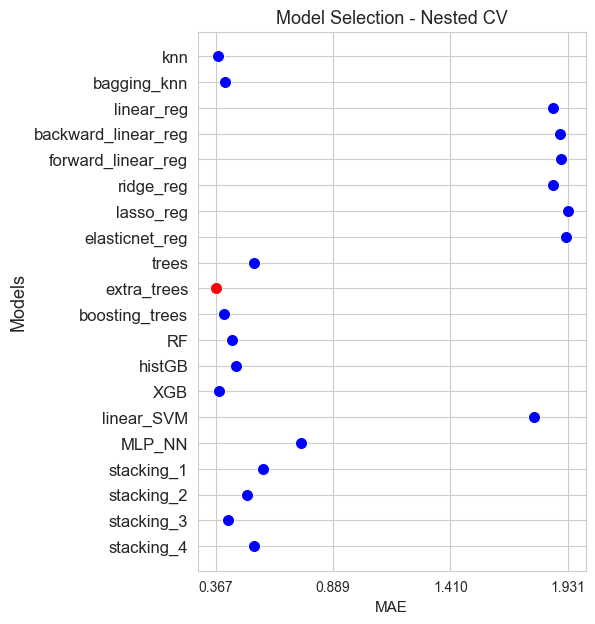

In [ ]:
plt.figure(figsize=(5, 7))
ax = sns.scatterplot(x=models_inner_scores, y=models_list, color='blue', s=75)
ax = sns.scatterplot(x=best_model_inner_score, y=[best_model], color='red', s=75)
plt.title('Model Selection - Nested CV', size=13)
ax.set_ylabel('Models', size=13)
ax.set_xlabel('MAE', size=11)
min = np.min(models_inner_scores)
max = np.max(models_inner_scores)
plt.xticks(np.round(np.linspace(min,max, 4), 3), fontsize=10)
plt.yticks(fontsize=12)
plt.show()

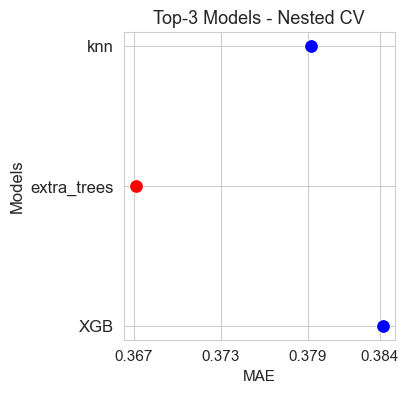

In [ ]:
limit = 0.40
plt.figure(figsize=(3.5, 4))
ax = sns.scatterplot(x=models_inner_scores[models_inner_scores < limit], 
                     y=models_list[models_inner_scores < limit], color='blue', s=100)
ax = sns.scatterplot(x=best_model_inner_score, y=[best_model], color='red', s=100)
plt.title('Top-3 Models - Nested CV', size=13)
ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=11)
min = np.min(models_inner_scores[models_inner_scores < limit])
max = np.max(models_inner_scores[models_inner_scores < limit])
plt.xticks(np.round(np.linspace(min,max, 4), 3), fontsize=11)
plt.yticks(fontsize=12)
plt.show()

#### **Best pipeline hyper-parameters**

In [ ]:
with open(rf'Results/best_params_{best_model}', 'rb') as file:
    best_params = pickle.load(file)

In [ ]:
best_params

{'preprocessing__quant__imputer__method': 'knn',
 'preprocessing__cat__imputer__method': 'simple_median',
 'preprocessing__quant__scaler__apply': True,
 'preprocessing__cat__discretizer__apply': True,
 'features_selector__method': 'not_select',
 'preprocessing__quant__imputer__n_neighbors': 1,
 'preprocessing__cat__discretizer__n_bins': 5,
 'preprocessing__cat__discretizer__strategy': 'kmeans',
 'extra_trees__n_estimators': 250,
 'extra_trees__max_depth': 30,
 'extra_trees__min_samples_split': 4,
 'extra_trees__min_samples_leaf': 2,
 'extra_trees__criterion': 'squared_error',
 'extra_trees__max_features': 1.0}

#### **Features selected**

Not feature selector applied, so, all the features has been selected.

In [ ]:
#selected_features = pipelines[best_model].steps[1][1].features_selector_.get_support(indices=True)
#selected_features = X.columns[selected_features]

### **Predictive analysis**

Predictive analysis of the best model.

#### **Estimation of future performance**

In [ ]:
with open(rf'Results/final_outer_score_{best_model}', 'rb') as file:
    best_model_future_performance = pickle.load(file)

In [ ]:
# Estimation of future performance by Nested CV 
best_model_future_performance

0.30113535145744197

- Using simple validation

   Is a more optimistic estimation of the model future performance, in comparison with the one obtain through nested evaluation.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, random_state=123)

In [ ]:
pipelines[best_model].set_params(**best_params)
pipelines[best_model].fit(X_train, Y_train)
Y_test_hat = pipelines[best_model].predict(X_test)
mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test)

0.30763731371627917

#### **Predictive plots**

Several predictive plot to make a diagnosis of the predictions.

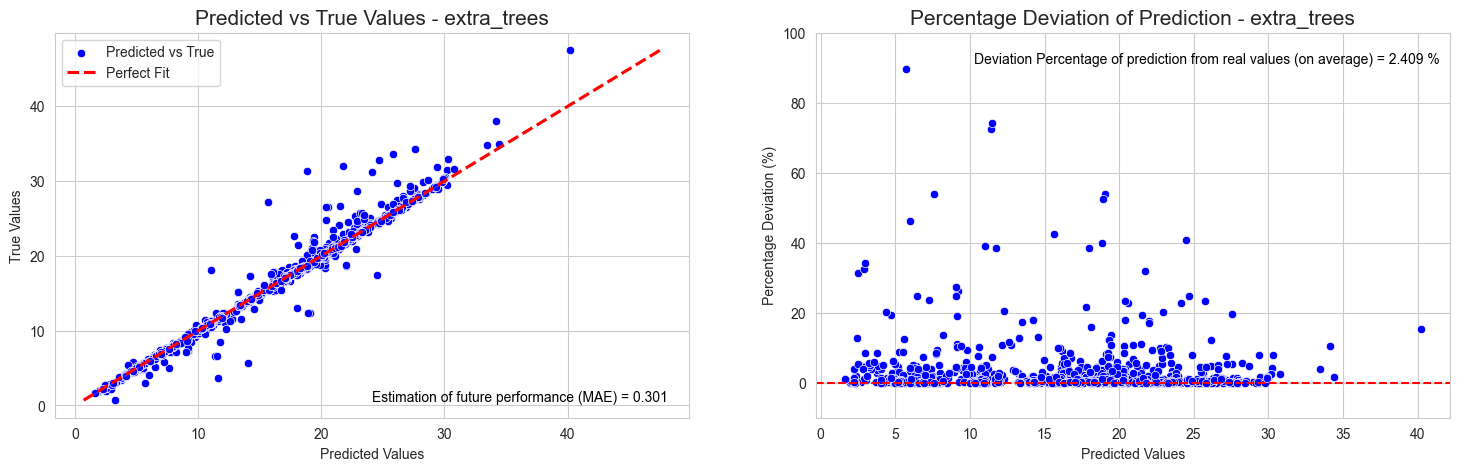

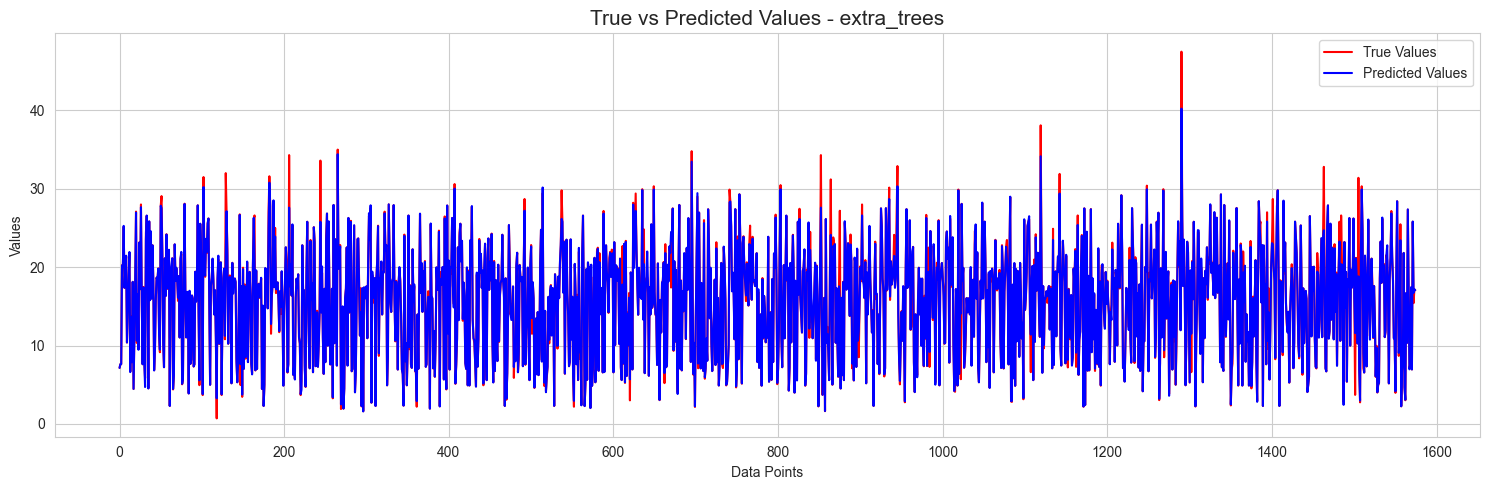

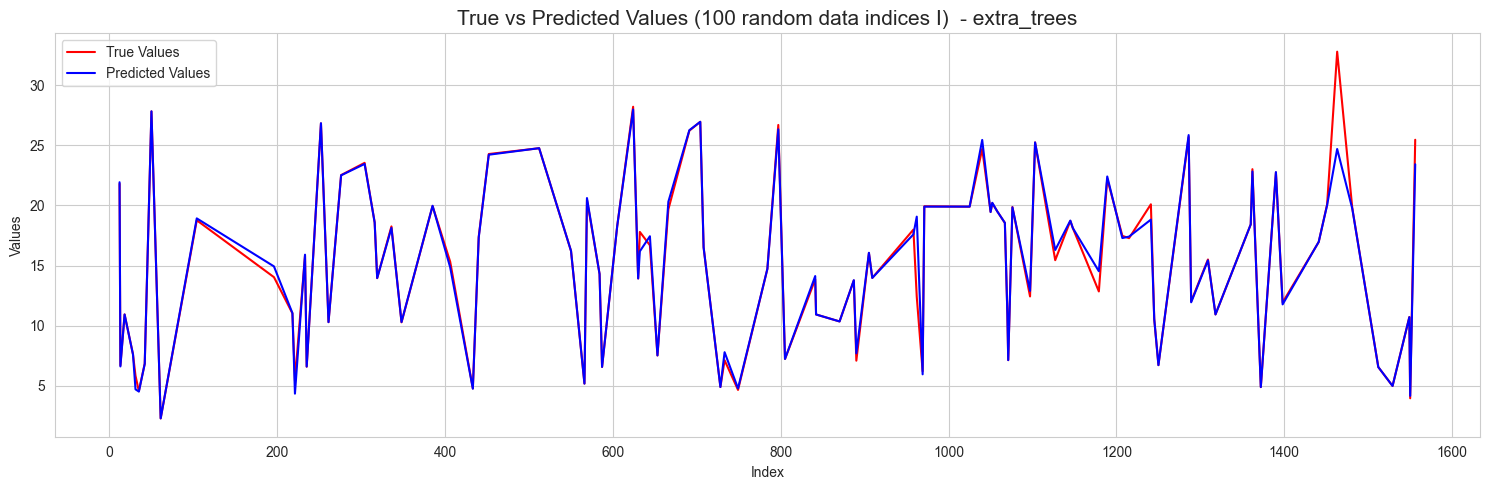

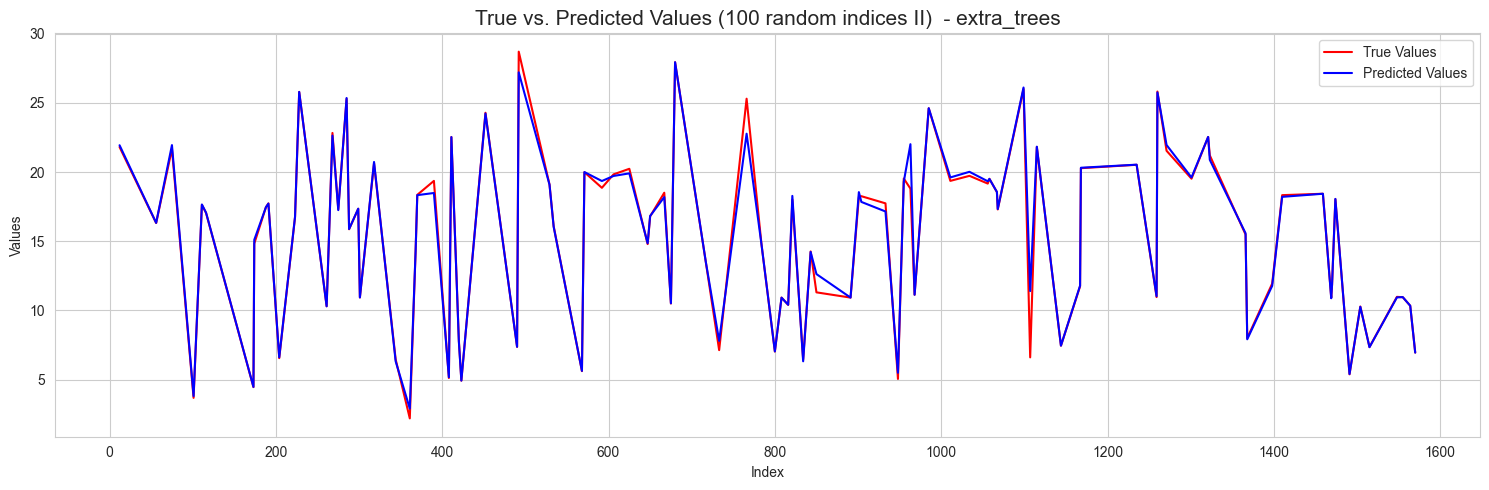

In [ ]:
predictive_plots(Y_test, Y_test_hat, model_name=best_model, future_performance=best_model_future_performance)

#### **Prediction Intervals**

Prediction intervals estimated by bootstrap.

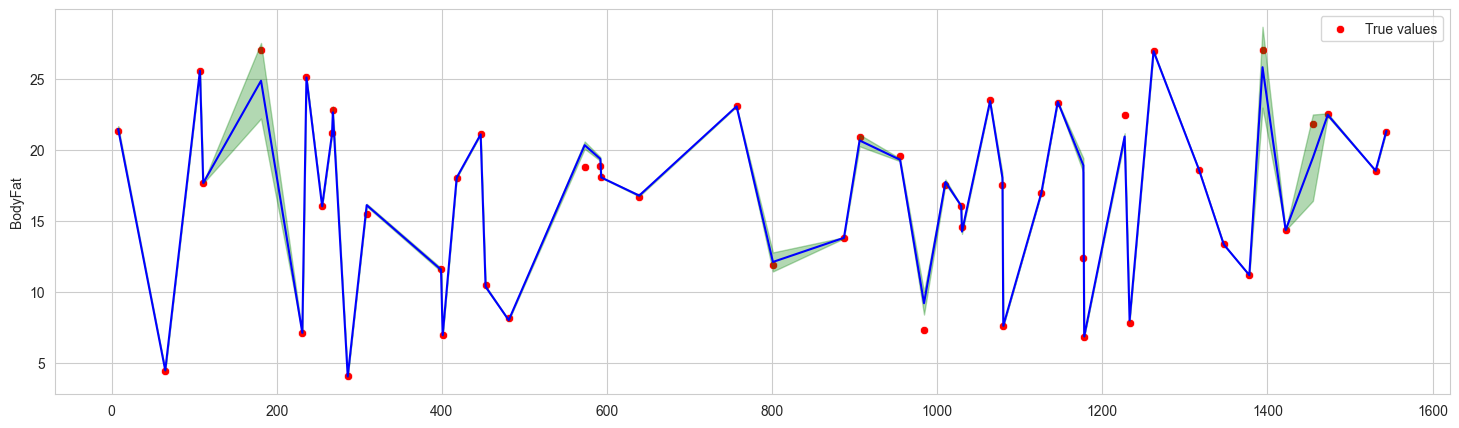

In [ ]:
pipelines[best_model].set_params(**best_params)
predictive_intervals(estimator=pipelines[best_model], B=250, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, n_points=50, random_state=1)
# Time: 17 mins

### **Inference**

#### **Coefficient interpretation of the best Linear Regression model**

In [ ]:
pipelines['linear_regression'].set_params(**best_params_linear_reg)
pipelines['linear_regression'].fit(X,Y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant',
                                                  Pipeline(steps=[('imputer',
                                                                   imputer(method='knn',
                                                                           n_nearest_features=7,
                                                                           n_neighbors=4)),
                                                                  ('scaler',
                                                                   scaler(apply=True))]),
                                                  ['Weight', 'Height', 'Neck',
                                                   'Chest', 'Abdomen', 'Hip',
                                                   'Thigh', 'Knee', 'Ankle',
                                                   'Biceps', 'Forearm',
                                                   'Wrist']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   imputer(method='simple_median',
                                                                           n_neighbors=4)),
                                                                  ('discretizer',
                                                                   discretizer(apply=True,
                                                                               n_bins=2,
                                                                               strategy='kmeans'))]),
                                                  ['Age'])])),
                ('features_selector', features_selector(method='not_select')),
                ('linear_regression', LinearRegression())])

In [ ]:
pipelines['linear_regression']['linear_regression'].intercept_

15.743755945434446

In [ ]:
lin_reg_coefficients = pipelines['linear_regression']['linear_regression'].coef_
lin_reg_coefficients

array([-7.64306405,  0.16251362, -0.88431254, -0.29332678, 11.18831405,
       -0.12280761, -0.55309937,  3.2059348 , -0.78069601,  0.71920713,
        1.61088777, -0.26988005,  0.1326339 ])

In [ ]:
X.columns

Index(['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh',
       'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist'],
      dtype='object')

**Interpretation according the best linear regression model:**

- If `Age` increases in one unit, `BodyFat` decreases in 7.64 units.

- If `Weight` increases in one unit, `BodyFat` increases in 0.16 units.

- If `Height` increases in one unit, `BodyFat` decreases in 0.88 units.

- If `Neck` increases in one unit, `BodyFat` decreases in 0.29 units.

- If `Chest` increases in one unit, `BodyFat` increases in 11.18 units.

- If `Abdomen` increases in one unit, `BodyFat` decreases in 0.12 units.

- If `Hip` increases in one unit, `BodyFat` decreases in 0.55 units.

- If `Thigh` increases in one unit, `BodyFat` increases in 3.20 units.

- If `Knee` increases in one unit, `BodyFat` decreases in 0.78 units.

- If `Ankle` increases in one unit, `BodyFat` increases in 0.72 units.

- If `Biceps` increases in one unit, `BodyFat` increases in 1.61 units.

- If `Forearm` increases in one unit, `BodyFat` decreases in 0.26 units.

- If `Wrist` increases in one unit, `BodyFat` increases in 0.13 units.


#### **Predictors importance analysis with the best Penalized Linear Regression model**

In [ ]:
pipelines['ridge_regression'].set_params(**best_params_ridge_reg)
pipelines['ridge_regression'].fit(X,Y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant',
                                                  Pipeline(steps=[('imputer',
                                                                   imputer(method='knn',
                                                                           n_nearest_features=6,
                                                                           n_neighbors=4)),
                                                                  ('scaler',
                                                                   scaler())]),
                                                  ['Weight', 'Height', 'Neck',
                                                   'Chest', 'Abdomen', 'Hip',
                                                   'Thigh', 'Knee', 'Ankle',
                                                   'Biceps', 'Forearm',
                                                   'Wrist']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   imputer(method='knn',
                                                                           n_nearest_features=3)),
                                                                  ('discretizer',
                                                                   discretizer(apply=True,
                                                                               n_bins=2,
                                                                               strategy='kmeans'))]),
                                                  ['Age'])])),
                ('ridge', Ridge(alpha=0.10000411830753107))])

In [ ]:
ridge_reg_coefficients = pipelines['ridge_regression']['ridge'].coef_
ridge_reg_coefficients

array([-0.29109788,  0.06633816, -0.4583522 , -0.04109189,  1.14626694,
       -0.02094284, -0.11598438,  1.70501731, -0.7585785 ,  0.28383903,
        1.05576006, -0.3803131 ,  0.132631  ])

In [ ]:
X.columns

Index(['Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh',
       'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist'],
      dtype='object')

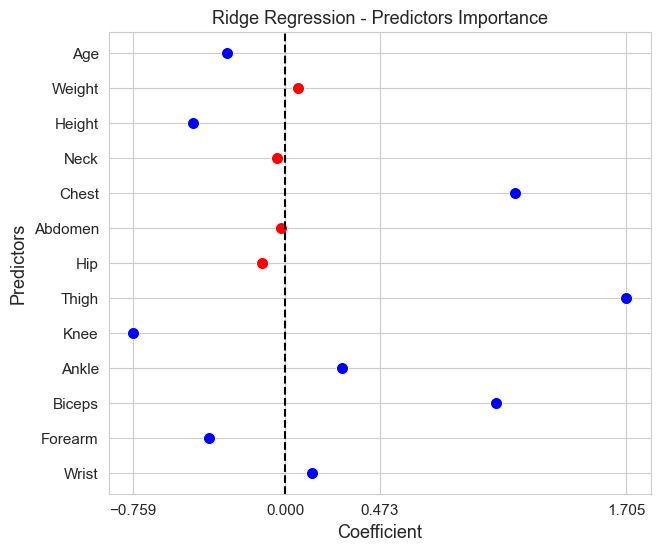

In [ ]:
plt.figure(figsize=(7, 6))
threshold = 0.12
filter = (ridge_reg_coefficients > -threshold) & (ridge_reg_coefficients < threshold)
ax = sns.scatterplot(x=ridge_reg_coefficients, y=X.columns, color='blue', s=75)
ax = sns.scatterplot(x=ridge_reg_coefficients[filter],
                     y=X.columns[filter], color='red', s=75)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Ridge Regression - Predictors Importance', size=13)
ax.set_ylabel('Predictors', size=13)
ax.set_xlabel('Coefficient', size=13)
min = np.min(ridge_reg_coefficients)
max = np.max(ridge_reg_coefficients)
plt.xticks(np.linspace(min,max, 3).tolist() + [0], fontsize=11)
plt.yticks(fontsize=11)
plt.show()

According to the best Ridge model:

- `Weight`, `Neck`, `Abdomen` and`Hip` are not signifivative predictors to explain the response variable `BodyFat`.